In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import sys


import percolating_cluster
import monopole_data

import wrappings
sys.path.append(os.path.join(os.path.dirname(
    os.path.abspath(''))))
import common.plots as plots
import common.scaler as scaler

pd.options.mode.chained_assignment = None


In [2]:
def fillup_copies(df):
   copy_num = df.groupby(['copy']).ngroups
   for i in range(copy_num - 1):
       df1 = df[df['copy'] == i]
       df2 = df[df['copy'] == i + 1]
       df3 = df1[~df1['conf'].isin(df2['conf'])]
       df3['copy'] = i + 1
       df = pd.concat([df, df3])
   return df.reset_index(drop=True)

def fill_funcational_max(df, groupby_keys):
    df2 = []
    copy_num = df.groupby(['copy']).ngroups
    for copy_max in range(copy_num):
        df1 = df[df['copy'] <= copy_max]
        df1 = df1.groupby(groupby_keys + ['conf'])['functional'].max().reset_index(level=groupby_keys + ['conf'])
        df2.append(df1.groupby(groupby_keys)['functional']\
                  .agg([('functional', 'mean'), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys))
        df2[-1]['copy'] = copy_max
    return pd.concat(df2).reset_index(drop=True)

In [3]:
def read_functional(paths):
    df = []
    for path in paths:
        if 'chain' in path:
            chain = path['chain']
        else:
            chain = '/'
        if 'padding' in path:
            padding = path['padding']
        else:
            padding = 4
        for i in range(path['conf_range'][0], path['conf_range'][1] + 1):
            data_path = path['path'] + f'_{i:0{padding}}'
            if(os.path.isfile(data_path)):
                df1 = pd.read_csv(data_path)
                if not df1.empty:
                    df.append(df1)
                    df[-1]['conf'] = chain + f'-{i}'
                    if 'parameters' in path:
                            for key, val in path['parameters'].items():
                                df[-1][key] = val
    return pd.concat(df)

In [4]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    output_path = f'{image_path}/{image_name}'
    print(output_path)
    fg.savefig(output_path, dpi=800, facecolor='white')

def save_csv(df, path, name):
    try:
        os.makedirs(path)
    except:
        pass
    df.to_csv(f'{path}/{name}', index=False)

# make plot
def make_plot(data, x, y, title, image_path, image_name, hue=None, err=None):
    fg = seaborn.FacetGrid(data=data, hue=hue, height=5,
                               aspect=1.61, legend_out=True)
    fg.figure.suptitle(title)
    if err == None:
        fg.map(plt.errorbar, x, y, mfc=None, fmt='o', ms=5, capsize=5, lw=0.5, ls=None
           ).add_legend()
    else:
        fg.map(plt.errorbar, x, y, err, mfc=None, fmt='o', ms=5, capsize=5, lw=0.5, ls=None
           ).add_legend()
    fg.ax.set_xlabel(x)
    fg.ax.set_ylabel(y)
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which='both', bottom=True,
                          top=True, left=True, right=True)
    fg.ax.set_yscale('log')
    plt.show()
    save_image(image_path, image_name, fg)

In [5]:
def get_best_copy(df):
    df = df.sort_values('functional')
    df['copy'] = np.sort(df['copy'])
    return df

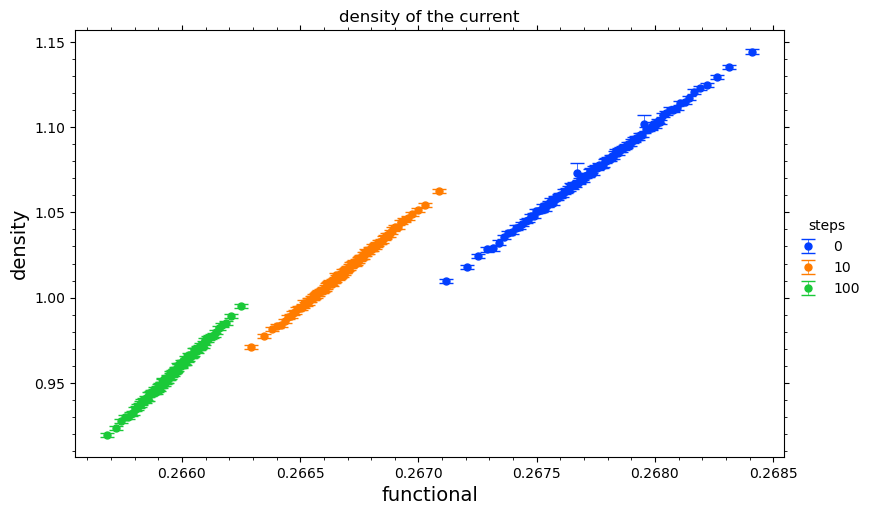

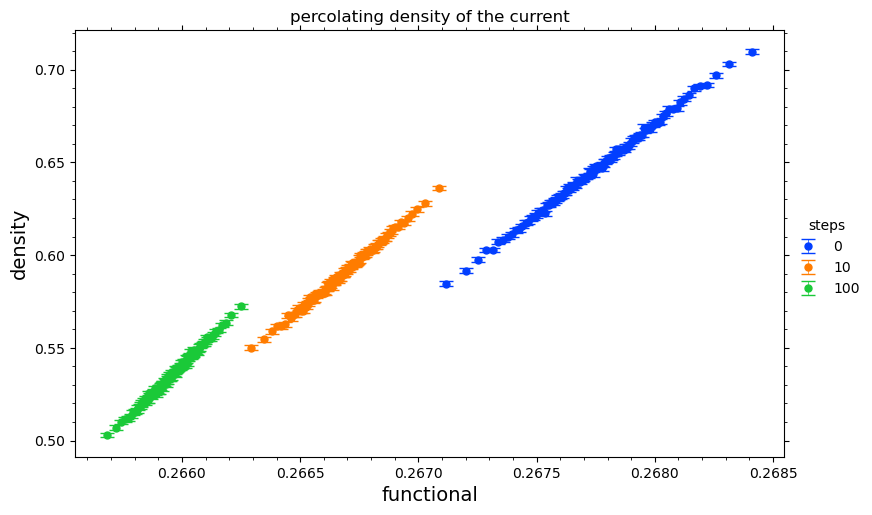

In [6]:
df = []
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
df[-1]['steps'] = 0
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
df[-1]['steps'] = 10
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
df[-1]['steps'] = 100
df = pd.concat(df)
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 10}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
df_func = read_functional(paths_functional)
df = df.merge(df_func, how='inner', on=['copy', 'steps', 'conf'])
df = df.groupby(['conf', 'steps']).apply(get_best_copy, include_groups=False).reset_index(level=['conf', 'steps'])
df = df.groupby(['copy', 'steps']).agg(density=('density', 'mean'), std_density=('density', 'sem'), density_percolating=('densitiy_percolating', 'mean'), std_density_percolating=('densitiy_percolating', 'sem'), functional=('functional', 'mean')).reset_index(level=['steps', 'copy'])
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'steps', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_0', True, err='std_density')
plots.make_plot(df, 'functional', 'density_percolating', 'steps', 'functional', 'density', 'percolating density of the current', '../../result/monopoles/su3/gluodynamics', 'density_percolating_size_24^4_beta_6p0_steps_0', True, err='std_density_percolating')

In [7]:
df = pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density')
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000)}]
df_func = read_functional(paths_functional)
df = df.merge(df_func, how='inner', on=['copy', 'conf'])
df.to_csv(f'../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density_functional.csv', index=False)

In [8]:
df = pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density')
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000)}]
df_func = read_functional(paths_functional)
df = df.merge(df_func, how='inner', on=['copy', 'conf'])
df.to_csv(f'../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density_functional.csv', index=False)

In [9]:
df = pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density')
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000)}]
df_func = read_functional(paths_functional)
df = df.merge(df_func, how='inner', on=['copy', 'conf'])
df.to_csv(f'../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density_functional.csv', index=False)

        density  densitiy_percolating  copy    conf  steps
0      1.097848              0.681503     0     /-1      0
1      1.167148              0.744821     1     /-1      0
2      1.097226              0.675365     2     /-1      0
3      1.100256              0.667363     3     /-1      0
4      1.075084              0.650893     4     /-1      0
...         ...                   ...   ...     ...    ...
99966  0.992033              0.557897    95  /-1000    100
99967  0.966861              0.565977    96  /-1000    100
99968  0.936173              0.543369    97  /-1000    100
99969  1.009280              0.571726    98  /-1000    100
99970  0.966084              0.514313    99  /-1000    100

[299958 rows x 5 columns]
    copy  functional    conf  beta  size  steps
0      0    0.821492     /-1   6.0  24^4      0
1      1    0.821263     /-1   6.0  24^4      0
2      2    0.821629     /-1   6.0  24^4      0
3      3    0.821472     /-1   6.0  24^4      0
4      4    0.821414     

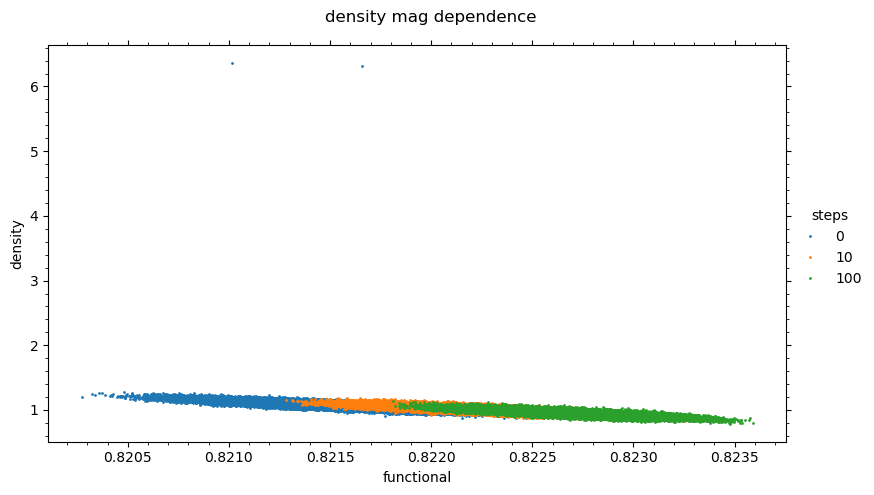

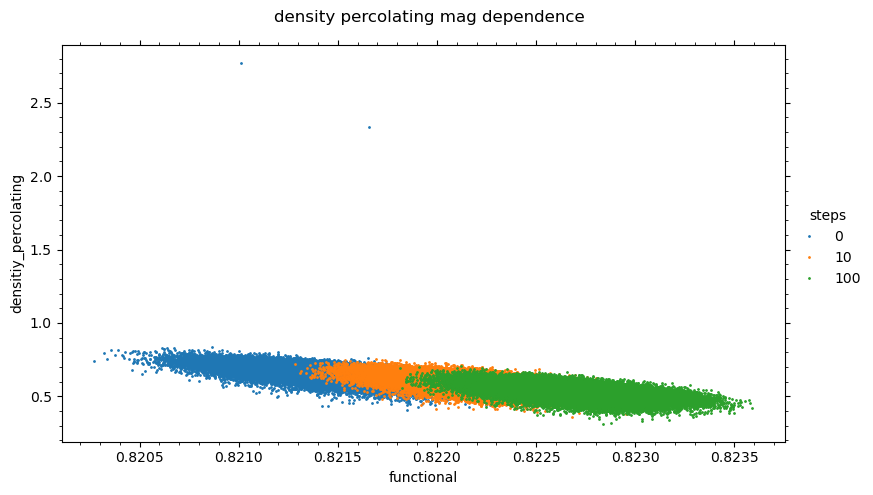

In [10]:
df = []
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
df[-1]['steps'] = 0
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
df[-1]['steps'] = 10
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
df[-1]['steps'] = 100
df = pd.concat(df)
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 10}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
df_func = read_functional(paths_functional)
print(df)
print(df_func)
df = df.merge(df_func, how='inner', on=['copy', 'steps', 'conf'])
print(df)
print(df[df['density'] <= 0.7])

fg = seaborn.FacetGrid(data=df, hue='steps', height=5,
                           aspect=1.61, legend_out=True)
fg.figure.suptitle(f'density mag dependence')
fg.map(plt.errorbar, 'functional', 'density', mfc=None, fmt='o', ms=1, capsize=5, lw=0.5, ls=None
       ).add_legend()
fg.ax.set_xlabel('functional')
fg.ax.set_ylabel('density')
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                      top=True, left=True, right=True)
plt.show()

fg = seaborn.FacetGrid(data=df, hue='steps', height=5,
                           aspect=1.61, legend_out=True)
fg.figure.suptitle(f'density percolating mag dependence')
fg.map(plt.errorbar, 'functional', 'densitiy_percolating', mfc=None, fmt='o', ms=1, capsize=5, lw=0.5, ls=None
       ).add_legend()
fg.ax.set_xlabel('functional')
fg.ax.set_ylabel('densitiy_percolating')
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                      top=True, left=True, right=True)
plt.show()

      functional1    conf
0        0.821467     /-1
2        0.821058    /-10
4        0.821313   /-100
6        0.821305  /-1000
8        0.821580   /-101
...           ...     ...
1990     0.821384   /-995
1992     0.821472   /-996
1994     0.820902   /-997
1996     0.821374   /-998
1998     0.821522   /-999

[1000 rows x 2 columns]
      functional2    conf
1        0.822170     /-1
3        0.821791    /-10
5        0.822051   /-100
7        0.822003  /-1000
9        0.822302   /-101
...           ...     ...
1991     0.822116   /-995
1993     0.822166   /-996
1995     0.821641   /-997
1997     0.822090   /-998
1999     0.822233   /-999

[1000 rows x 2 columns]
     functional1    conf  functional2
0       0.821467     /-1     0.822170
1       0.821058    /-10     0.821791
2       0.821313   /-100     0.822051
3       0.821305  /-1000     0.822003
4       0.821580   /-101     0.822302
..           ...     ...          ...
995     0.821384   /-995     0.822116
996     0.821472   /-9

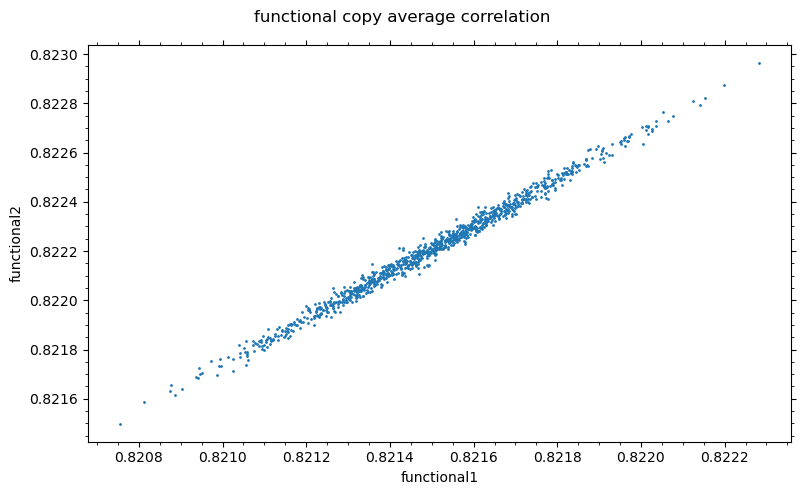

In [11]:
steps1 = 0
steps2 = 10
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_{steps1}/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': steps1}},
                    {'path': f'../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_{steps2}/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': steps2}}]
df_func = read_functional(paths_functional)
df_func = df_func.groupby(['conf', 'steps']).agg(functional=('functional', 'mean'), std_functional=('functional', 'sem')).reset_index(level=['conf', 'steps'])
df1 = df_func[df_func['steps'] == steps1][['functional', 'conf']]
df1 = df1.rename({'functional': 'functional1'}, axis=1)
print(df1)
df2 = df_func[df_func['steps'] == steps2][['functional', 'conf']]
df2 = df2.rename({'functional': 'functional2'}, axis=1)
print(df2)
df = df1.merge(df2, how='inner', on=['conf'])
print(df)
fg = seaborn.FacetGrid(data=df, height=5,
                           aspect=1.61, legend_out=True)
fg.figure.suptitle(f'functional copy average correlation')
fg.map(plt.errorbar, 'functional1', 'functional2', mfc=None, fmt='o', ms=1, capsize=5, lw=0.5, ls=None
       ).add_legend()
fg.ax.set_xlabel('functional1')
fg.ax.set_ylabel('functional2')
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                      top=True, left=True, right=True)
plt.show()

In [12]:
df = []
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
df[-1]['steps'] = 0
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
df[-1]['steps'] = 10
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
df[-1]['steps'] = 100
df = pd.concat(df)
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 10}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
df_func = read_functional(paths_functional)
df = df.merge(df_func, how='inner', on=['copy', 'steps', 'conf'])
print(df)


         density  densitiy_percolating  copy    conf  steps  functional  beta  \
0       1.097848              0.681503     0     /-1      0    0.821492   6.0   
1       1.167148              0.744821     1     /-1      0    0.821263   6.0   
2       1.097226              0.675365     2     /-1      0    0.821629   6.0   
3       1.100256              0.667363     3     /-1      0    0.821472   6.0   
4       1.075084              0.650893     4     /-1      0    0.821414   6.0   
...          ...                   ...   ...     ...    ...         ...   ...   
299953  0.992033              0.557897    95  /-1000    100    0.822383   6.0   
299954  0.966861              0.565977    96  /-1000    100    0.822536   6.0   
299955  0.936173              0.543369    97  /-1000    100    0.822580   6.0   
299956  1.009280              0.571726    98  /-1000    100    0.822523   6.0   
299957  0.966084              0.514313    99  /-1000    100    0.822488   6.0   

        size  
0       24^4

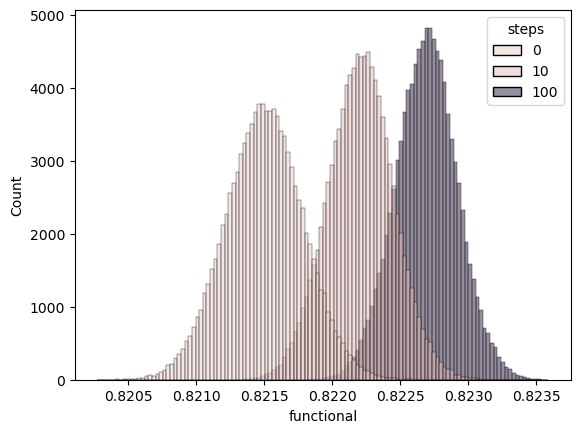

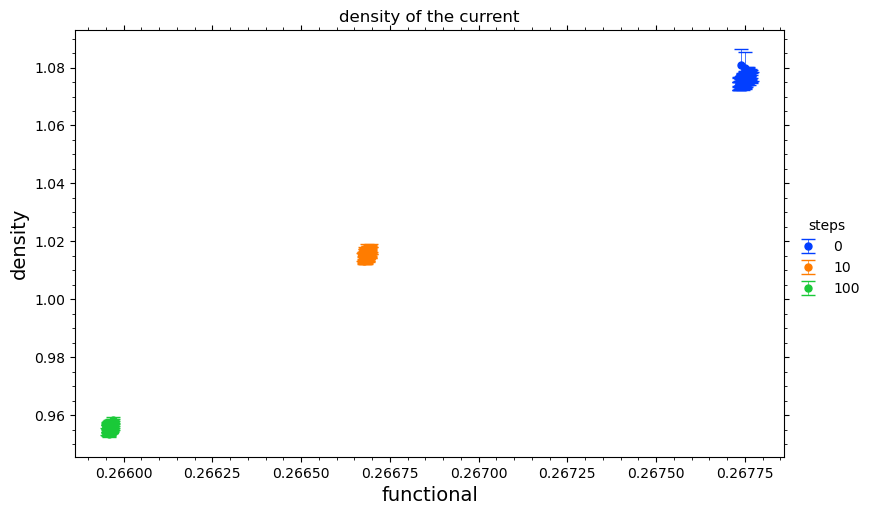

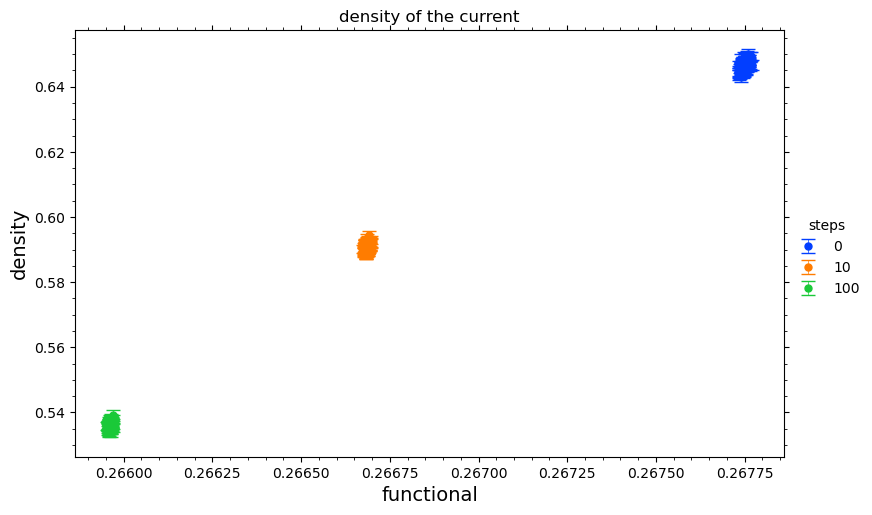

In [13]:
df = []
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
df[-1]['steps'] = 0
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
df[-1]['steps'] = 10
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
df[-1]['steps'] = 100
df = pd.concat(df)
df = df.groupby(['copy', 'steps']).agg(density=('density', 'mean'), std_density=('density', 'sem'), density_percolating=('densitiy_percolating', 'mean'), std_density_percolating=('densitiy_percolating', 'sem'))
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 10}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
df_func = read_functional(paths_functional)
seaborn.histplot(df_func, x='functional', hue='steps')
df_func = df_func.groupby(['copy', 'steps']).agg(functional=('functional', 'mean'), std_functional=('functional', 'sem')).reset_index(level=['copy', 'steps'])
df = df.merge(df_func, how='inner', on=['copy', 'steps'])
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'steps', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_0', True, err='std_density')
plots.make_plot(df, 'functional', 'density_percolating', 'steps', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_percolating_size_24^4_beta_6p0_steps_0', True, err='std_density_percolating')

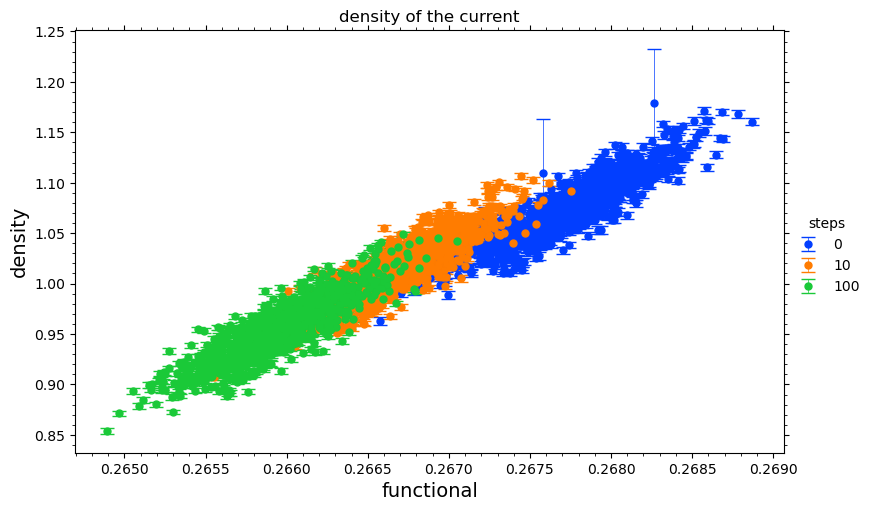

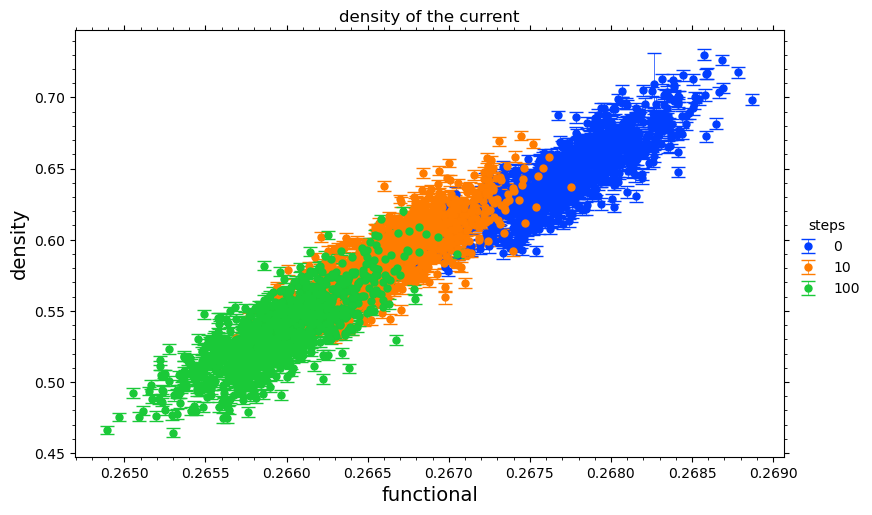

In [14]:
df = []
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
df[-1]['steps'] = 0
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
df[-1]['steps'] = 10
df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
df[-1]['steps'] = 100
df = pd.concat(df)
df = df.groupby(['conf', 'steps']).agg(density=('density', 'mean'), std_density=('density', 'sem'), density_percolating=('densitiy_percolating', 'mean'), std_density_percolating=('densitiy_percolating', 'sem')).reset_index(level=['conf', 'steps'])
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 10}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
df_func = read_functional(paths_functional)
df_func = df_func.groupby(['conf', 'steps']).agg(functional=('functional', 'mean'), std_functional=('functional', 'sem')).reset_index(level=['conf', 'steps'])
df = df.merge(df_func, how='inner', on=['conf', 'steps'])
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'steps', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_0', True, err='std_density')
plots.make_plot(df, 'functional', 'density_percolating', 'steps', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_percolating_size_24^4_beta_6p0_steps_0', True, err='std_density_percolating')

In [6]:
def functional_bin(df):
    df_binned = pd.DataFrame()
    bins = np.histogram_bin_edges(df['functional'], bins='auto')
    for i in range(0, len(bins) - 2):
        df_tmp = df[(df['functional'] >= bins[i]) & (df['functional'] < bins[i + 1])]
        df_tmp['bin'] = int(i)
        df_binned = pd.concat([df_binned, df_tmp])
    df_tmp = df[(df['functional'] >= bins[len(bins) - 2]) & (df['functional'] <= bins[len(bins) - 1])]
    df_tmp['bin'] = int(len(bins) - 2)
    df_binned = pd.concat([df_binned, df_tmp])
    return df_binned

In [7]:
def get_data_best_copy():
    df = []
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
    df[-1]['steps'] = 0
    df[-1]['type'] = '0_best'
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
    df[-1]['steps'] = 10
    df[-1]['type'] = '10_best'
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
    df[-1]['steps'] = 100
    df[-1]['type'] = '100_best'
    df = pd.concat(df)
    paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '0_best'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '10_best'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '100_best'}}]
    df_func = read_functional(paths_functional)
    df = df.merge(df_func, how='inner', on=['copy', 'type', 'conf'])
    df = df.groupby(['conf', 'type']).apply(get_best_copy, include_groups=False).reset_index(level=['conf', 'type'])
    df = df.groupby(['copy', 'type']).agg(density=('density', 'mean'), std_density=('density', 'sem'), density_percolating=('densitiy_percolating', 'mean'), std_density_percolating=('densitiy_percolating', 'sem'), functional=('functional', 'mean')).reset_index(level=['type', 'copy'])
    df['functional'] = (1 - df['functional']) * 3/2
    df = df.drop('copy', axis=1)
    return df

In [12]:
def get_data_bin_copy():
    df = []
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/density'))
    df[-1]['steps'] = 0
    df[-1]['type'] = '24_0_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/density'))
    df[-1]['steps'] = 10
    df[-1]['type'] = '24_10_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/density'))
    df[-1]['steps'] = 100
    df[-1]['type'] = '24_100_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0_1e-15/copies=100/density'))
    df[-1]['steps'] = 0
    df[-1]['type'] = '24_0_1e-15_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100_1e-15/copies=100/density'))
    df[-1]['steps'] = 100
    df[-1]['type'] = '24_100_1e-15_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/16^4/beta6.0/steps_0/copies=100/density'))
    df[-1]['steps'] = 0
    df[-1]['type'] = '16_0_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/16^4/beta6.0/steps_10/copies=100/density'))
    df[-1]['steps'] = 10
    df[-1]['type'] = '16_10_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/16^4/beta6.0/steps_100/copies=100/density'))
    df[-1]['steps'] = 100
    df[-1]['type'] = '16_100_bin'
    # print(df[-1])
    df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=100/density'))
    df[-1]['steps'] = 0
    df[-1]['type'] = '32_0_bin'
    print(df[-1])
    # df.append(pd.read_csv('../../result/monopoles_su3/gluodynamics/32^4/beta6.0/steps_100/copies=100/density'))
    # df[-1]['steps'] = 100
    # df[-1]['type'] = '32_100_bin'
    # print(df[-1])
    df = pd.concat(df)
    print(df[df['type'] == '32_0_bin'])
    paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '24_0_bin'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '24_10_bin'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '24_100_bin'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0_1e-15/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '24_0_1e-15_bin'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100_1e-15/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'type': '24_100_1e-15_bin'}},
                        {'path': '../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_0/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'type': '16_0_bin'}, 'padding': 5},
                        {'path': '../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_10/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'type': '16_10_bin'}, 'padding': 5},
                        {'path': '../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_100/copies=100/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'type': '16_100_bin'}, 'padding': 5},
                        {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=100/s1/functional', 'conf_range': (1, 500), 'parameters': {'beta': 6.0, 'size': '32^4', 'type': '32_0_bin'}, 'chain': 's1'}]
                        # {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=100/s2/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'type': '32_0_bin', 'chain': 2}}]
                        # {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_100/copies=100/s1/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'type': '32_100_bin', 'chain': 1}},
                        # {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_100/copies=100/s2/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'type': '32_100_bin', 'chain': 2}}]
    df_func = read_functional(paths_functional)
    print(df_func[df_func['type'] == '32_0_bin'])
    df = df.merge(df_func, how='inner', on=['copy', 'type', 'conf'])
    print(df[df['type'] == '32_0_bin'])
    df = functional_bin(df)
    df = df.groupby(['bin', 'type']).agg(density=('density', 'mean'), std_density=('density', 'sem'), density_percolating=('densitiy_percolating', 'mean'), std_density_percolating=('densitiy_percolating', 'sem'), functional=('functional', 'mean')).reset_index(level=['type', 'bin'])
    df['functional'] = (1 - df['functional']) * 3/2
    df = df.drop('bin', axis=1)
    return df

        density  densitiy_percolating  copy    conf  steps      type
0      1.040475              0.635145     0    s1-2      0  32_0_bin
1      1.102937              0.641659     1    s1-2      0  32_0_bin
2      1.067712              0.648960     2    s1-2      0  32_0_bin
3      1.086615              0.644290     3    s1-2      0  32_0_bin
4      1.077348              0.654295     4    s1-2      0  32_0_bin
...         ...                   ...   ...     ...    ...       ...
49895  1.053356              0.634309    95  s1-500      0  32_0_bin
49896  1.048341              0.643872    96  s1-500      0  32_0_bin
49897  1.091605              0.686865    97  s1-500      0  32_0_bin
49898  1.041876              0.620175    98  s1-500      0  32_0_bin
49899  1.058789              0.633646    99  s1-500      0  32_0_bin

[49900 rows x 6 columns]
        density  densitiy_percolating  copy    conf  steps      type
0      1.040475              0.635145     0    s1-2      0  32_0_bin
1      1

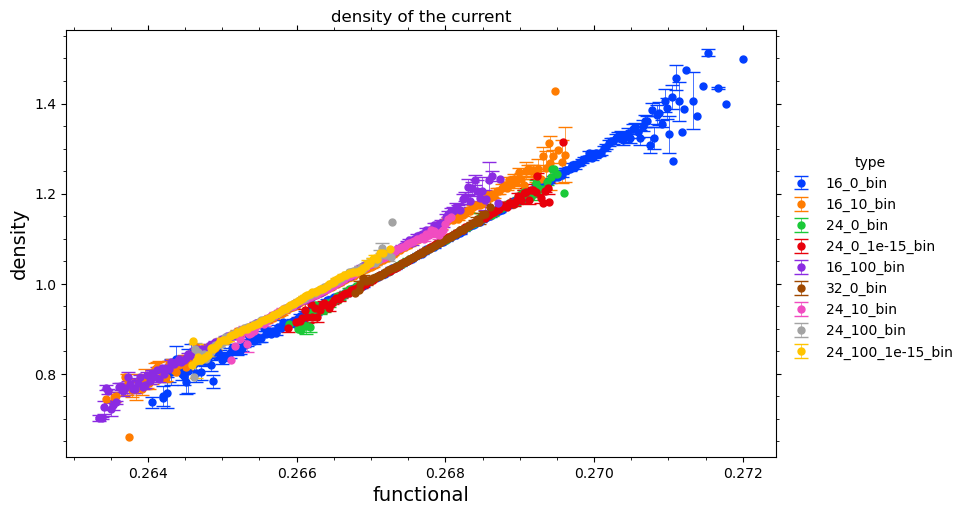

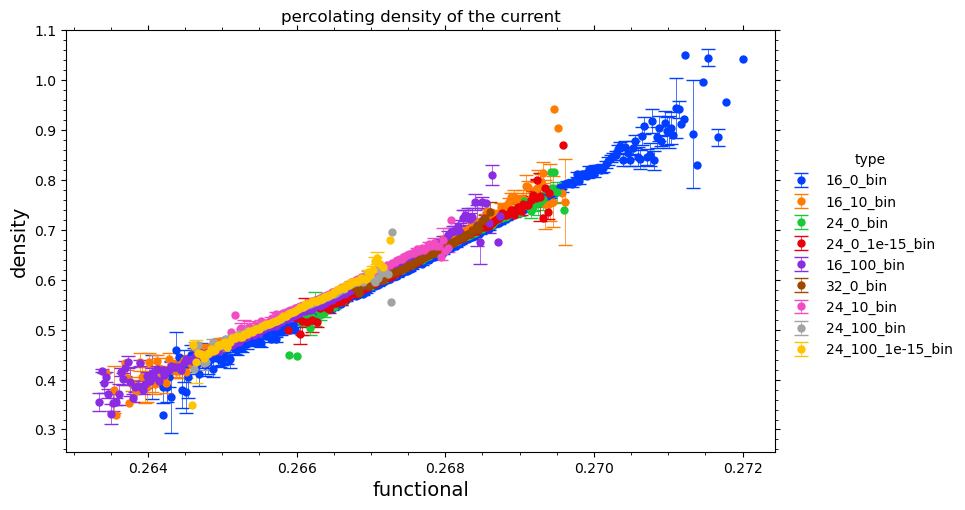

In [13]:
# df1 = get_data_best_copy()
# print(df1)
df  = get_data_bin_copy()
# print(df2)
# df = pd.concat([df1, df2])
# print(df)
plots.make_plot(df, 'functional', 'density', 'type', 'functional', 'density', 'density of the current', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_0', True, err='std_density')
plots.make_plot(df, 'functional', 'density_percolating', 'type', 'functional', 'density', 'percolating density of the current', '../../result/monopoles/su3/gluodynamics', 'density_percolating_size_24^4_beta_6p0_steps_0', True, err='std_density_percolating')

In [25]:
df_unwrapped = pd.read_csv('/home/ilya/soft/lattice/observables/data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped_1879_0')
df_wrapped = pd.read_csv('/home/ilya/soft/lattice/observables/data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_wrapped/clusters_wrapped_1879_0')
beta = 'beta6.0'
size = '24^4'
r0 = scaler.get_r0(float(beta[4:]))
lattice_volume = eval(size.replace('x', '*').replace('^', '**'))
df_wrapped['density'] = df_wrapped['length'] / lattice_volume / r0 ** 3
df_unwrapped['density'] = df_unwrapped['length'] * df_unwrapped['number'] / lattice_volume / r0 ** 3
df_wrapped = df_wrapped[['color', 'density']]
df_unwrapped = df_unwrapped[['color', 'density']]
print(df_unwrapped)
print(df_wrapped)
df = pd.concat([df_wrapped, df_unwrapped])
df = df.groupby('color')['density'].agg([('density', 'sum')]).reset_index(level='color')
print(df)
density_mean = df['density'].mean()
print(density_mean)

    color   density
0       1  0.633956
1       1  0.341218
2       1  0.152895
3       1  0.093229
4       1  0.050344
5       1  0.071786
6       1  0.029833
7       1  0.075515
8       1  0.027969
9       1  0.010255
10      1  0.012120
11      1  0.039156
12      1  0.014917
13      1  0.033562
14      1  0.018646
15      1  0.025172
16      1  0.031698
17      1  0.039156
18      1  0.051276
19      1  0.092297
20      2  0.673112
21      2  0.352405
22      2  0.175270
23      2  0.083906
24      2  0.027969
25      2  0.065260
26      2  0.029833
27      2  0.033562
28      2  0.009323
29      2  0.033562
30      2  0.024240
31      2  0.015849
32      2  0.016781
33      2  0.017713
34      2  0.040088
35      2  2.758642
36      3  0.648873
37      3  0.352405
38      3  0.145437
39      3  0.130520
40      3  0.055937
41      3  0.052208
42      3  0.029833
43      3  0.033562
44      3  0.030766
45      3  0.022375
46      3  0.024240
47      3  0.026104
48      3  0.018646


In [33]:
def cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, groupby_keys, image_path, image_name, path_csv, name_csv, hue=None):
    df_func = read_functional(paths_functional)
    df_func = fill_funcational_max(df_func, groupby_keys)
    df_clusters_wrapped = monopole_data.read_data_wrapped_copies(paths_clusters_wrapped)
    df_clusters_wrapped = df_clusters_wrapped.set_index(groupby_keys).groupby(groupby_keys).apply(fillup_copies, include_groups=False).reset_index(level=groupby_keys)
    df_clusters_unwrapped = monopole_data.read_data_unwrapped_copies(paths_clusters_unwrapped)
    df_clusters_unwrapped = df_clusters_unwrapped.set_index(groupby_keys).groupby(groupby_keys).apply(fillup_copies, include_groups=False).reset_index(level=groupby_keys)
    df_clusters_wrapped['density'] = df_clusters_wrapped['length'] / df_clusters_wrapped['lattice_size'] / df_clusters_wrapped['r0'] ** 3
    df_clusters_unwrapped['density'] = df_clusters_unwrapped['length'] * df_clusters_unwrapped['number'] / df_clusters_unwrapped['lattice_size'] / df_clusters_unwrapped['r0'] ** 3
    df_clusters_wrapped = df_clusters_wrapped[groupby_keys + ['color', 'conf', 'density', 'copy']]
    df_clusters_unwrapped = df_clusters_unwrapped[groupby_keys + ['color', 'conf', 'density', 'copy']]
    df = pd.concat([df_clusters_wrapped, df_clusters_unwrapped])
    df = df.groupby(groupby_keys + ['color', 'conf', 'copy'])['density'].agg([('density', 'sum')]).reset_index(level=groupby_keys + ['color', 'conf'])
    df = df.groupby(groupby_keys + ['conf', 'copy'])['density'].agg([('density', 'mean')]).reset_index(level=groupby_keys + ['conf'])
    df = df.groupby(groupby_keys + ['copy'])['density'].agg([('density', 'mean'), ('std_density', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys)
    df = df.merge(df_func, how='inner', on=groupby_keys + ['copy'])
    save_csv(df, path_csv, name_csv)
    plots.make_plot(df, 'functional', 'density', hue, 'functional', 'density', 'density of the current', image_path, image_name, True, err='std_density')

In [36]:
def cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, groupby_keys, image_path, image_name, path_csv, name_csv, hue=None):
    df_func = read_functional(paths_functional)
    df_func = fill_funcational_max(df_func, groupby_keys)
    print(df_func)
    df_clusters_wrapped = monopole_data.read_data_wrapped_copies(paths_clusters_wrapped)
    df_clusters_wrapped = df_clusters_wrapped.set_index(groupby_keys).groupby(groupby_keys).apply(fillup_copies, include_groups=False).reset_index(level=groupby_keys)
    df_clusters_unwrapped = monopole_data.read_data_unwrapped_copies(paths_clusters_unwrapped)
    df_clusters_unwrapped = df_clusters_unwrapped.set_index(groupby_keys).groupby(groupby_keys).apply(fillup_copies, include_groups=False).reset_index(level=groupby_keys)
    df_clusters_unwrapped.loc[df_clusters_unwrapped['length'] < df_clusters_unwrapped['length_threshold'], 'length'] = 0
    df_clusters_unwrapped['density'] = df_clusters_unwrapped['length'] * df_clusters_unwrapped['number'] / df_clusters_unwrapped['lattice_size'] / df_clusters_unwrapped['r0'] ** 3
    df_clusters_wrapped['length'] = df_clusters_wrapped['length'] / df_clusters_wrapped['lattice_size'] / df_clusters_wrapped['r0'] ** 3
    df_clusters_wrapped = df_clusters_wrapped.set_index(groupby_keys + ['color', 'conf', 'copy']).groupby(groupby_keys + ['color', 'conf', 'copy'])\
                                            .apply(percolating_cluster.find_percolating_wrapped_sum, include_groups=False)\
                                            .reset_index(level=groupby_keys + ['color', 'conf', 'copy'])
    df_clusters_wrapped = df_clusters_wrapped.rename(columns={'length': 'density'})
    df_clusters_wrapped = df_clusters_wrapped[groupby_keys + ['color', 'conf', 'density', 'copy']]
    df_clusters_unwrapped = df_clusters_unwrapped[groupby_keys + ['color', 'conf', 'density', 'copy']]
    df = pd.concat([df_clusters_unwrapped, df_clusters_wrapped])
    df = df.groupby(groupby_keys + ['color', 'conf', 'copy'])['density'].agg([('density', 'sum')]).reset_index(level=groupby_keys + ['color', 'conf'])
    df = df.groupby(groupby_keys + ['conf', 'copy'])['density'].agg([('density', 'mean')]).reset_index(level=groupby_keys + ['conf'])
    df = df.groupby(groupby_keys + ['copy'])['density'].agg([('density', 'mean'), ('std_density', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys)
    print(df_func)
    df = df.merge(df_func, how='inner', on=groupby_keys + ['copy'])
    save_csv(df, path_csv, name_csv)
    plots.make_plot(df, 'functional', 'density', hue, 'functional', 'density', 'density of the current', image_path, image_name, True, err='std_density')

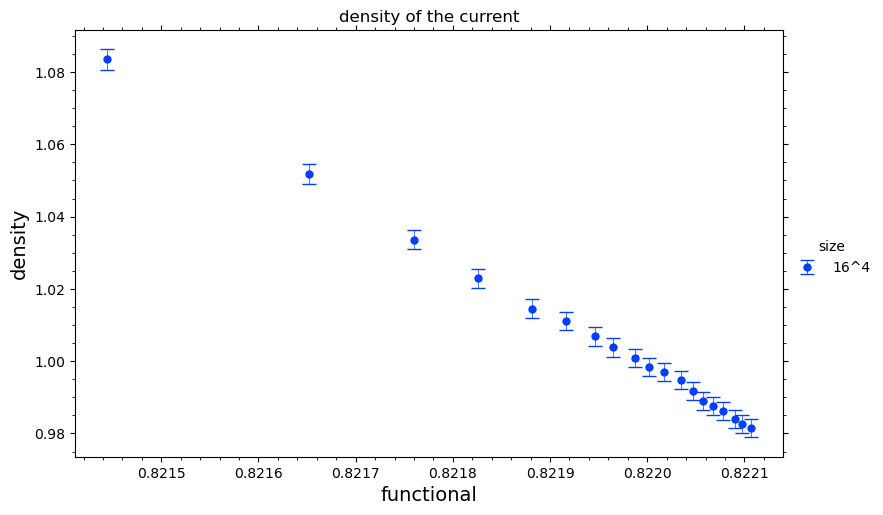

    beta  size  steps  functional       std  copy
0    6.0  16^4      0    0.821445  0.000017     0
1    6.0  16^4      0    0.821652  0.000016     1
2    6.0  16^4      0    0.821760  0.000016     2
3    6.0  16^4      0    0.821826  0.000015     3
4    6.0  16^4      0    0.821882  0.000015     4
5    6.0  16^4      0    0.821916  0.000015     5
6    6.0  16^4      0    0.821946  0.000015     6
7    6.0  16^4      0    0.821965  0.000015     7
8    6.0  16^4      0    0.821987  0.000015     8
9    6.0  16^4      0    0.822002  0.000015     9
10   6.0  16^4      0    0.822017  0.000015    10
11   6.0  16^4      0    0.822034  0.000015    11
12   6.0  16^4      0    0.822047  0.000015    12
13   6.0  16^4      0    0.822058  0.000015    13
14   6.0  16^4      0    0.822067  0.000015    14
15   6.0  16^4      0    0.822078  0.000015    15
16   6.0  16^4      0    0.822090  0.000015    16
17   6.0  16^4      0    0.822097  0.000015    17
18   6.0  16^4      0    0.822106  0.000015    18


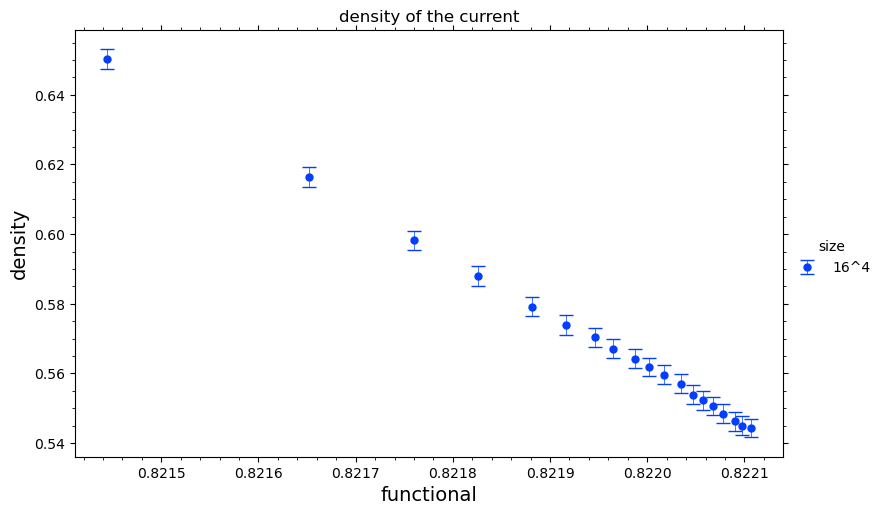

In [37]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 0}, 'padding': 5}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 0, 'lattice_size': 4*16**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 0, 'lattice_size': 4*16**4, 'r0': scaler.get_r0(6), 'length_threshold': 500}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 16^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_16^4_beta_6p0_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 16^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_16^4_beta_6p0_steps_0', hue='size')

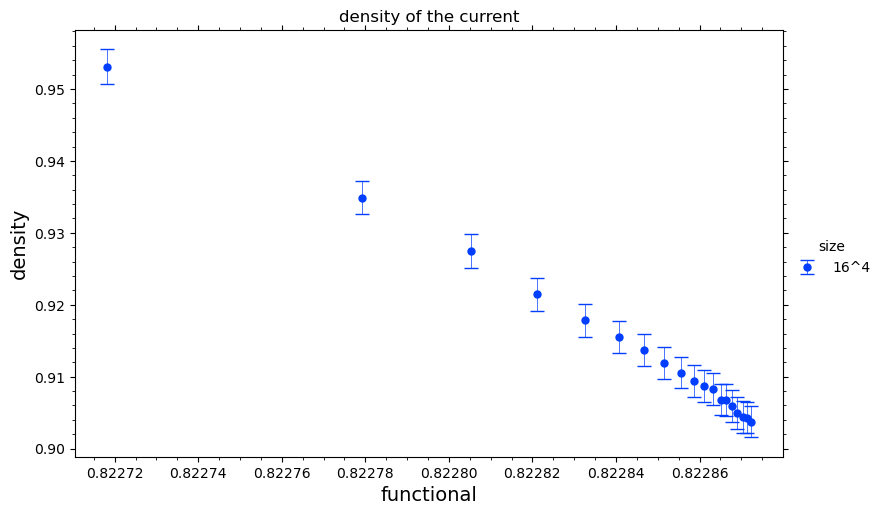

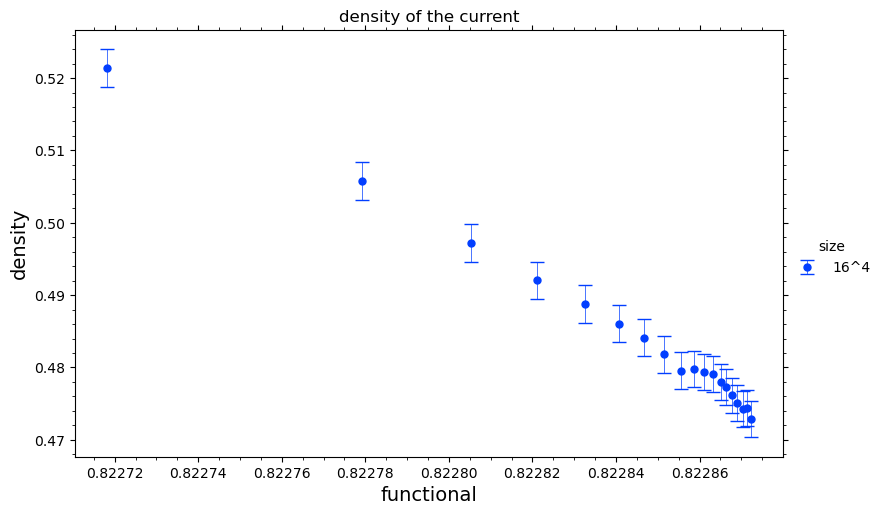

In [14]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_500/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 500}, 'padding': 5}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_500/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 500, 'lattice_size': 4*16**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_500/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '16^4', 'steps': 500, 'lattice_size': 4*16**4, 'r0': scaler.get_r0(6), 'length_threshold': 500}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 16^4 beta 6p0 steps 500', '../../result/monopoles/su3/gluodynamics', 'density_size_16^4_beta_6p0_steps_500', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 16^4 beta 6p0 steps 500', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_16^4_beta_6p0_steps_500', hue='size')

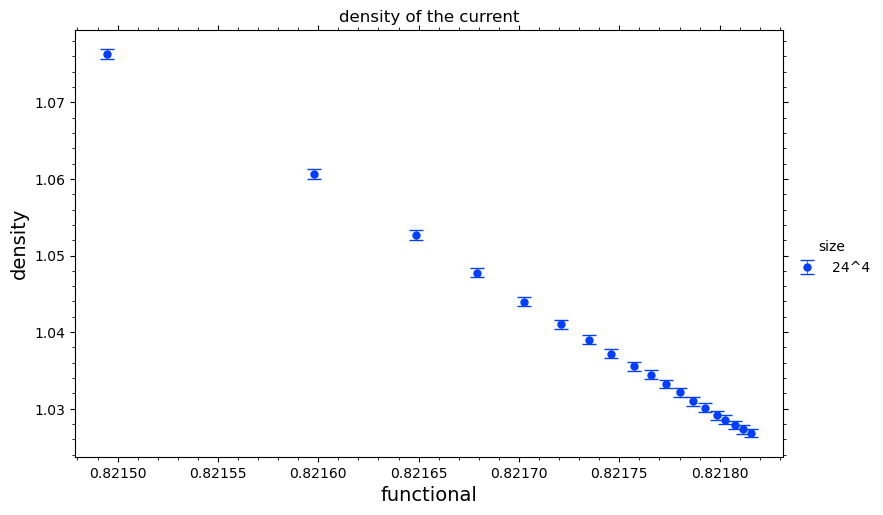

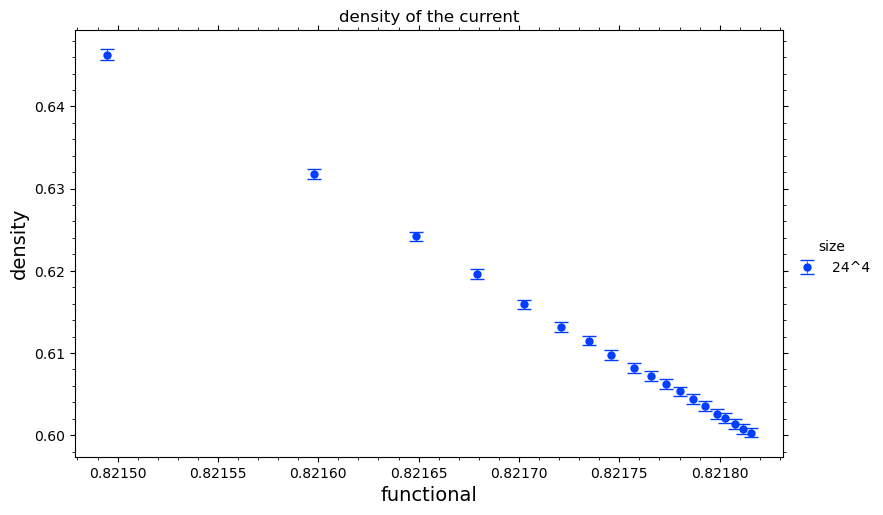

In [15]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0, 'lattice_size': 4*24**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 0, 'lattice_size': 4*24**4, 'r0': scaler.get_r0(6), 'length_threshold': 1500}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 24^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 24^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_24^4_beta_6p0_steps_0', hue='size')

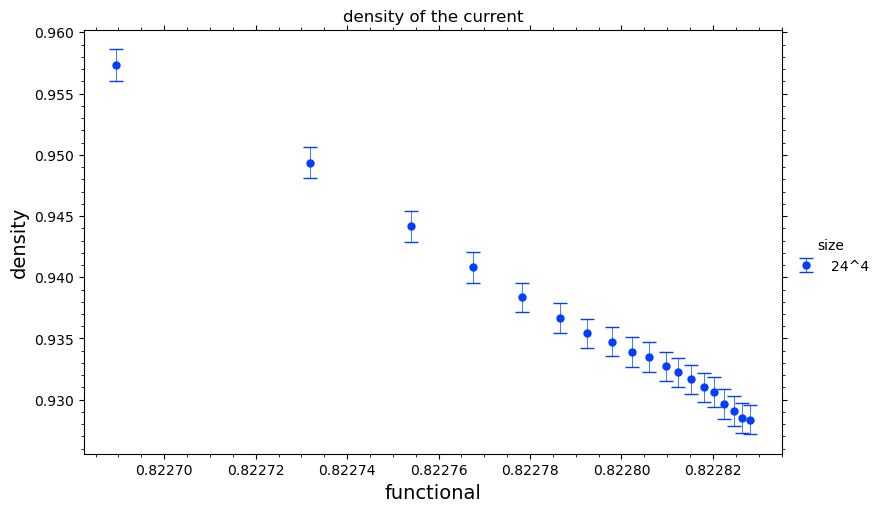

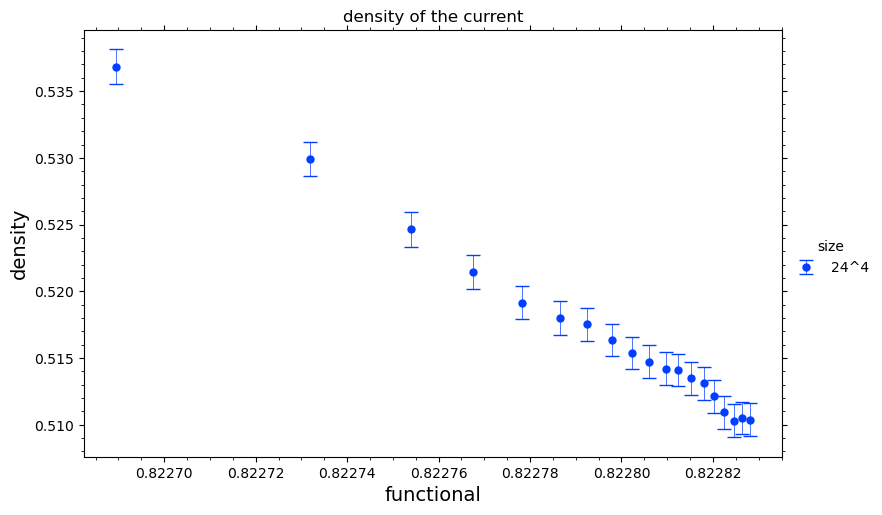

In [16]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100, 'lattice_size': 4*24**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '24^4', 'steps': 100, 'lattice_size': 4*24**4, 'r0': scaler.get_r0(6), 'length_threshold': 1500}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 24^4 beta 6p0 steps 100', '../../result/monopoles/su3/gluodynamics', 'density_size_24^4_beta_6p0_steps_100', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 24^4 beta 6p0 steps 100', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_24^4_beta_6p0_steps_100', hue='size')

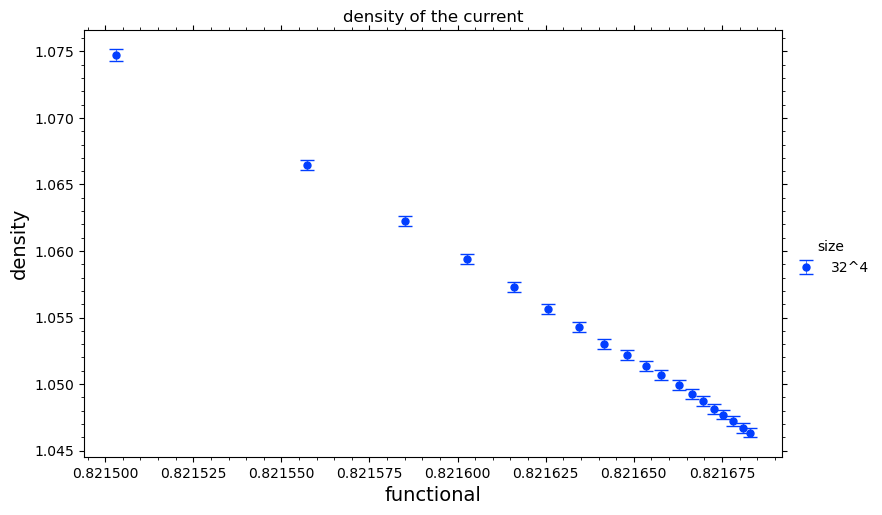

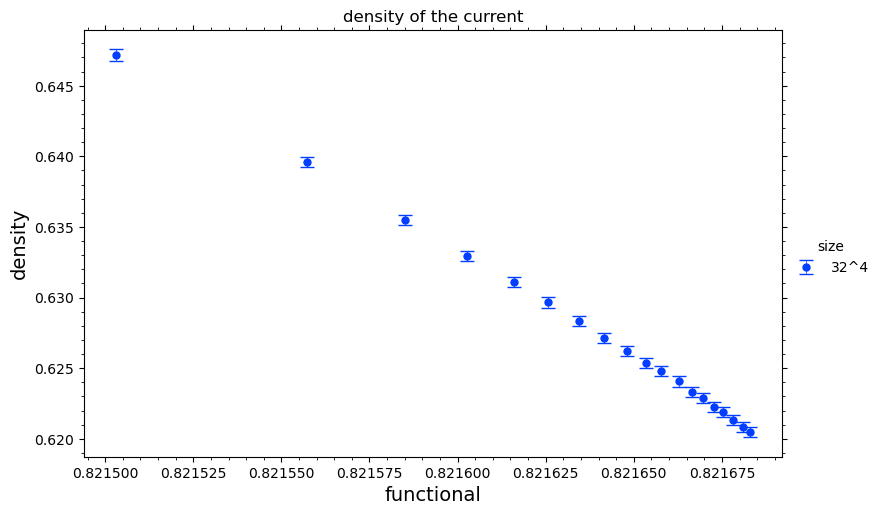

In [17]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s2/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0}, 'chain': 2}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19, 'chain': 1},
                          {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s2/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19, 'chain': 2}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6), 'length_threshold': 5000}, 'copies_num': 19, 'chain': 1},
                            {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s2/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6), 'length_threshold': 5000}, 'copies_num': 19, 'chain': 2}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 32^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_32^4_beta_6p0_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 32^4 beta 6p0 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_32^4_beta_6p0_steps_0', hue='size')

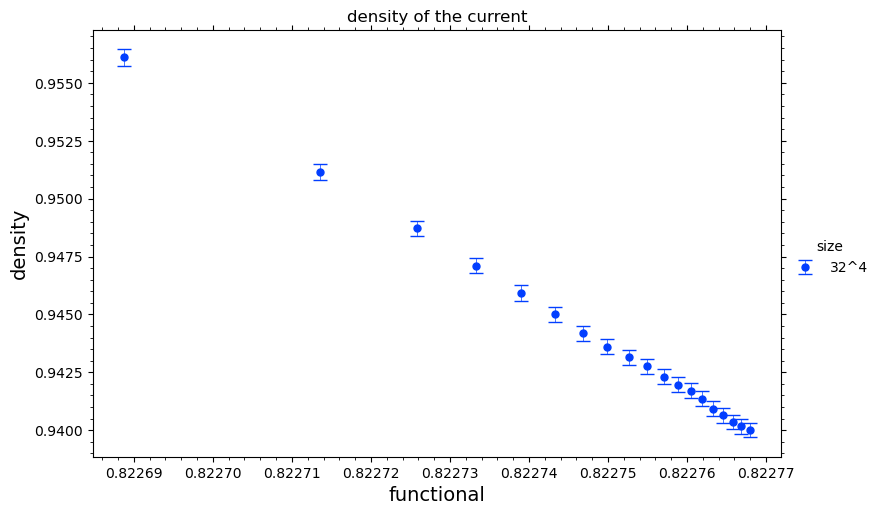

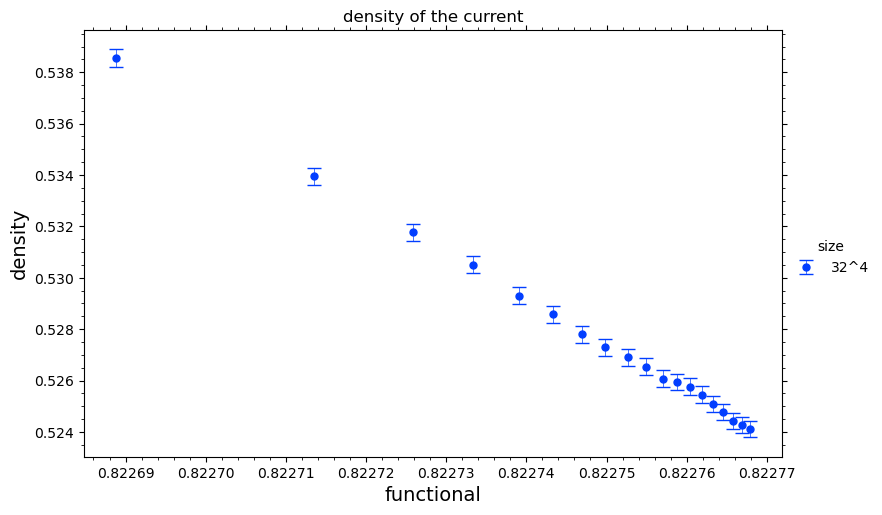

In [18]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s1/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s2/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100}, 'chain': 2}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19, 'chain': 1},
                          {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s2/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6)}, 'copies_num': 19, 'chain': 2}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6), 'length_threshold': 5000}, 'copies_num': 19, 'chain': 1},
                            {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_100/copies=20/s2/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0, 'size': '32^4', 'steps': 100, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6), 'length_threshold': 5000}, 'copies_num': 19, 'chain': 2}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size_32^4 beta 6p0 steps 100', '../../result/monopoles/su3/gluodynamics', 'density_size_32^4_beta_6p0_steps_100', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 32^4 beta 6p0 steps 100', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_32^4_beta_6p0_steps_100', hue='size')

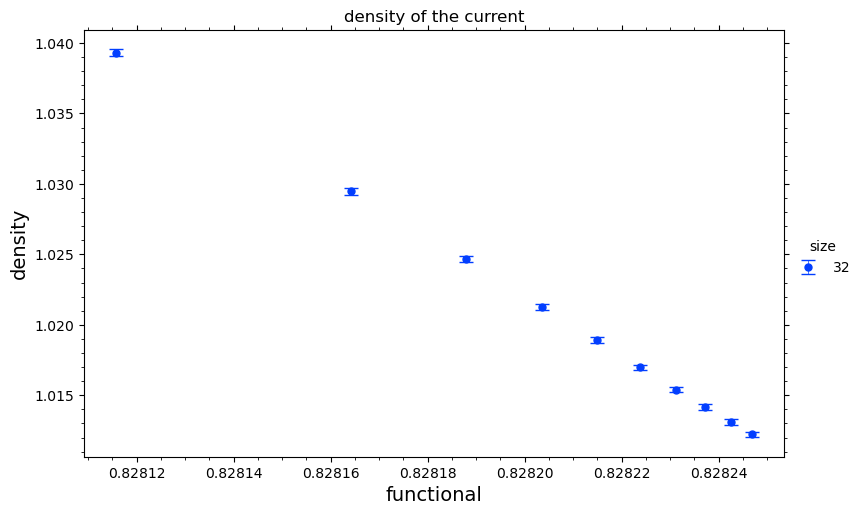

In [19]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 2},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 3},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 4}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 1},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 2},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 3},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 4}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 1},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 2},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 3},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 4}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 36^4 beta 6p1 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_36^4_beta_6p1_steps_0', hue='size')

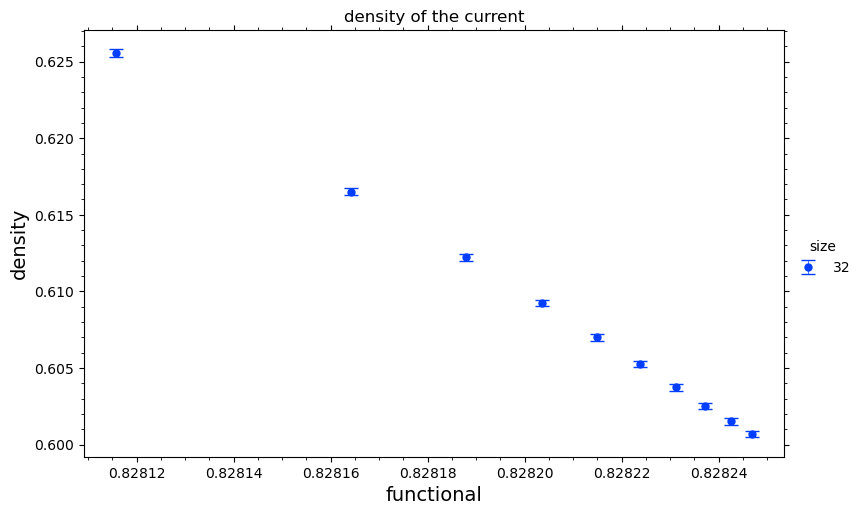

In [20]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 2},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 3},
                    {'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/functional', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0}, 'chain': 4}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 1},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 2},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 3},
                          {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 10, 'chain': 4}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 1},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s2/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 2},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 3},
                            {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'beta': 6.1, 'size': 32, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 6000}, 'copies_num': 10, 'chain': 4}]
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 36^4 beta 6p1 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_36^4_beta_6p1_steps_0', hue='size')

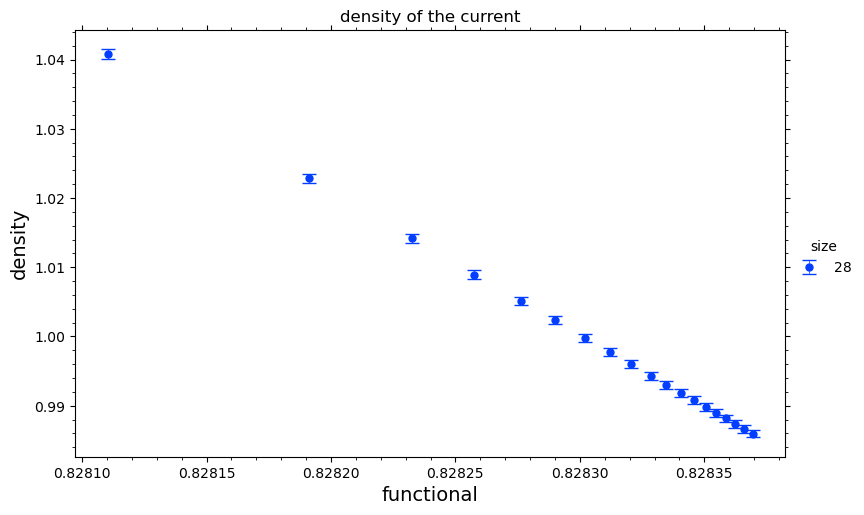

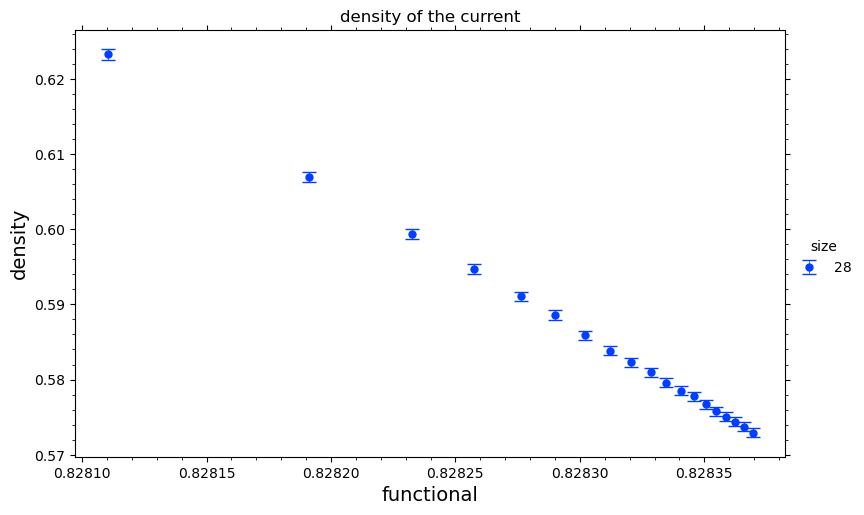

In [21]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.1, 'size': 28, 'steps': 0}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.1, 'size': 28, 'steps': 0, 'lattice_size': 4*28**4, 'r0': scaler.get_r0(6.1)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.1, 'size': 28, 'steps': 0, 'lattice_size': 4*28**4, 'r0': scaler.get_r0(6.1), 'length_threshold': 3000}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 28^4 beta 6p1 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_28^4_beta_6p1_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 28^4 beta 6p1 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_28^4_beta_6p1_steps_0', hue='size')

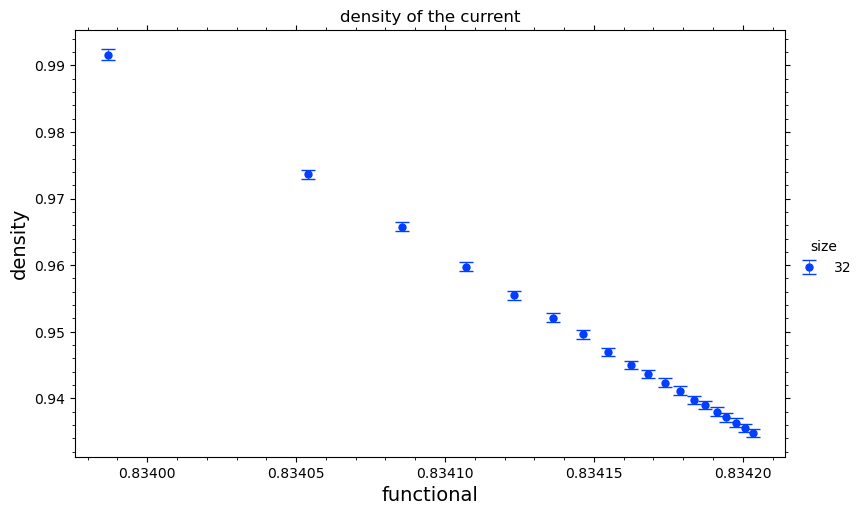

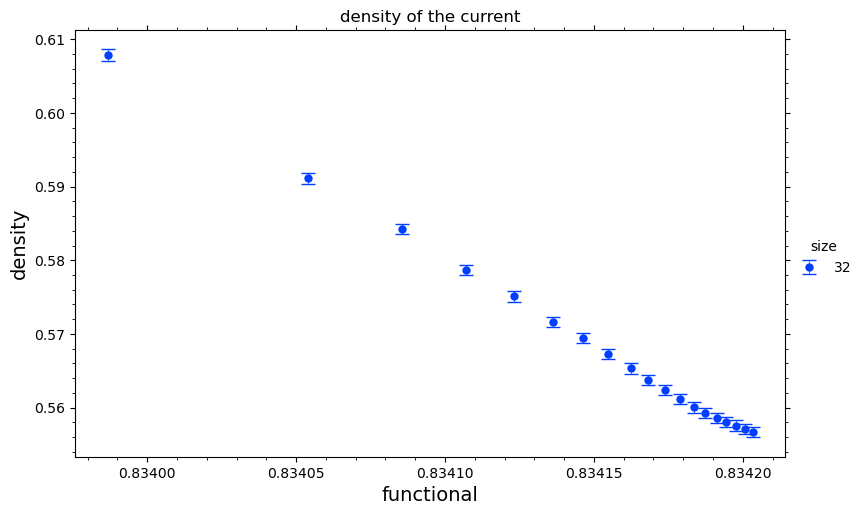

In [22]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.2, 'size': 32, 'steps': 0}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.2, 'size': 32, 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6.2)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.2, 'size': 32, 'steps': 0, 'lattice_size': 4*32**4, 'r0': scaler.get_r0(6.2), 'length_threshold': 2000}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 32^4 beta 6p2 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_32^4_beta_6p2_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 32^4 beta 6p2 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_32^4_beta_6p2_steps_0', hue='size')

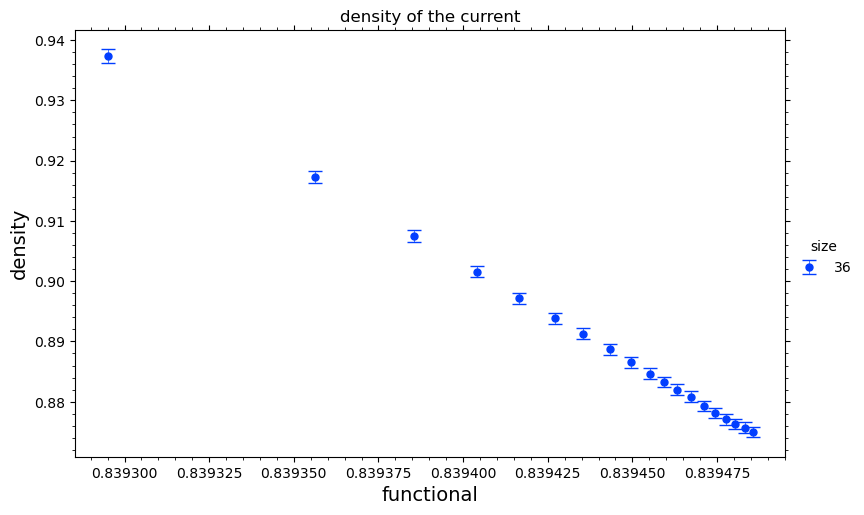

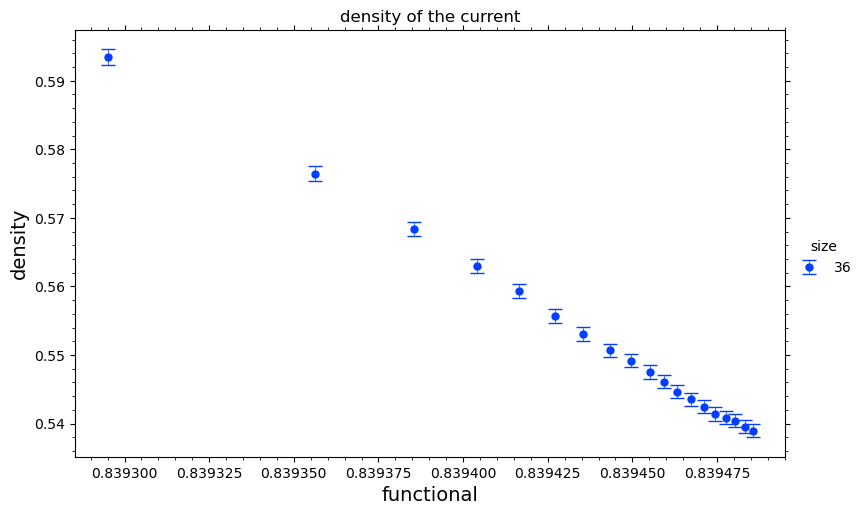

In [23]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.3, 'size': 36, 'steps': 0}}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.3, 'size': 36, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.3)}, 'copies_num': 19}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.3, 'size': 36, 'steps': 0, 'lattice_size': 4*36**4, 'r0': scaler.get_r0(6.3), 'length_threshold': 2000}, 'copies_num': 19}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 36^4 beta 6p3 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_36^4_beta_6p3_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 36^4 beta 6p3 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_36^4_beta_6p3_steps_0', hue='size')

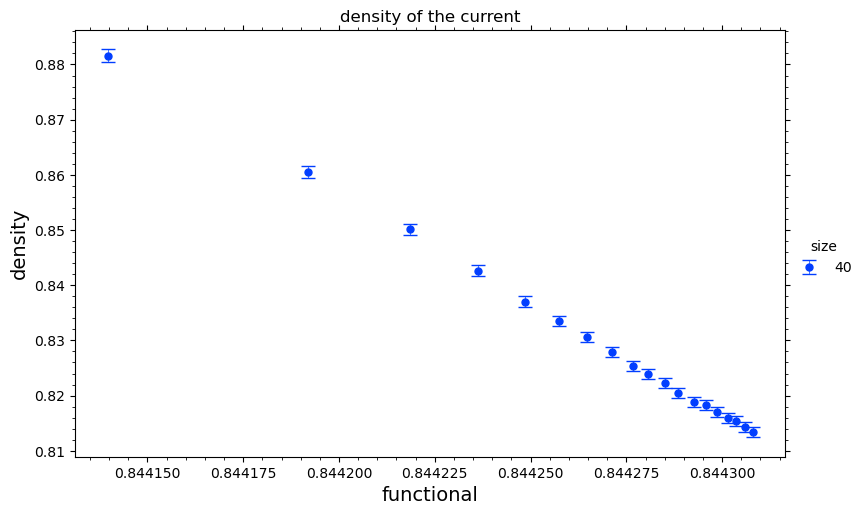

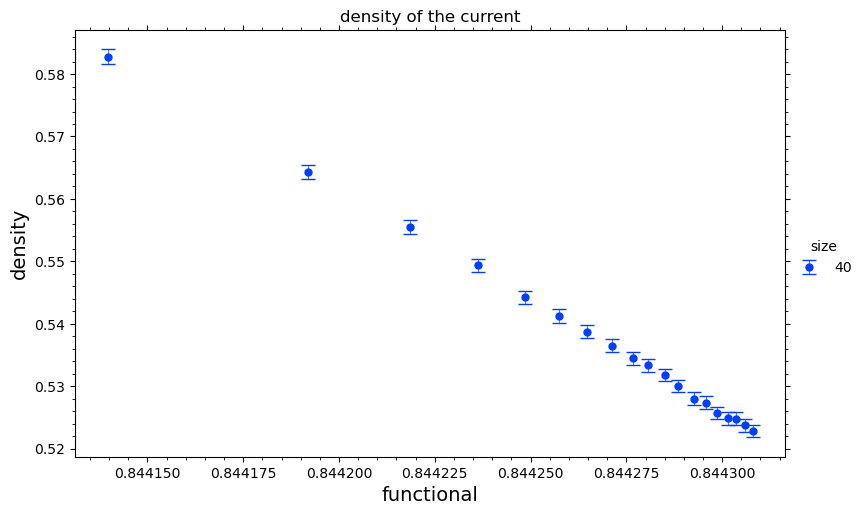

In [26]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s2/functional', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0}, 'chain': 2}]
paths_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0, 'lattice_size': 4*40**4, 'r0': scaler.get_r0(6.4)}, 'copies_num': 19, 'chain': 1},
                          {'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s2/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0, 'lattice_size': 4*40**4, 'r0': scaler.get_r0(6.4)}, 'copies_num': 19, 'chain': 2}]
paths_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0, 'lattice_size': 4*40**4, 'r0': scaler.get_r0(6.4), 'length_threshold': 2000}, 'copies_num': 19, 'chain': 1},
                            {'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s2/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.4, 'size': 40, 'steps': 0, 'lattice_size': 4*40**4, 'r0': scaler.get_r0(6.4), 'length_threshold': 2000}, 'copies_num': 19, 'chain': 2}]
cluster_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current density size 40^4 beta 6p4 steps 0', '../../result/monopoles/su3/gluodynamics', 'density_size_40^4_beta_6p4_steps_0', hue='size')
cluster_percolating_density(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, ['beta', 'size', 'steps'], '../../images/monopoles/su3/gluodynamics', 'current percolating density size 40^4 beta 6p4 steps 0', '../../result/monopoles/su3/gluodynamics', 'percolating_density_size_40^4_beta_6p4_steps_0', hue='size')

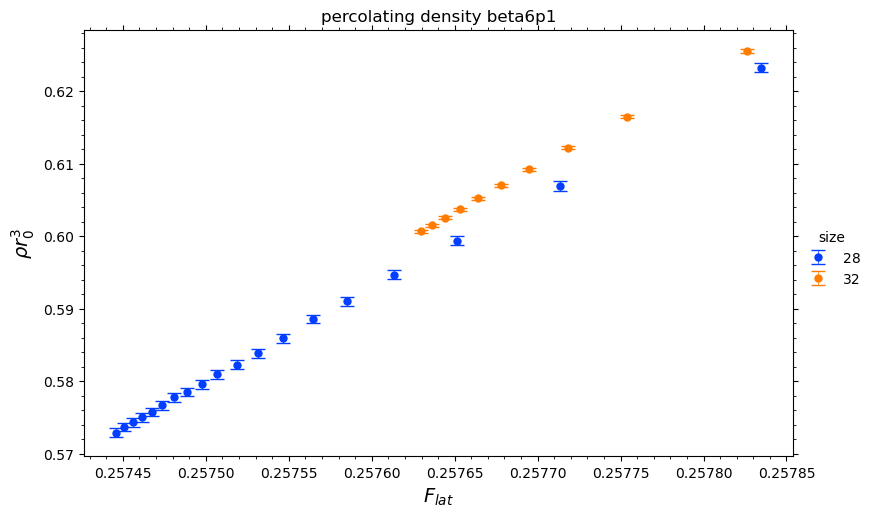

In [9]:
df = []
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_28^4_beta_6p1_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_36^4_beta_6p1_steps_0'))
df = pd.concat(df)
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'size', r'$F_{lat}$', r'$\rho r_{0}^{3}$', 'percolating density beta6p1', '../../images/monopoles/su3/gluodynamics', 'percolating_density_beta6p1', True, err='std_density', save_figure=True)

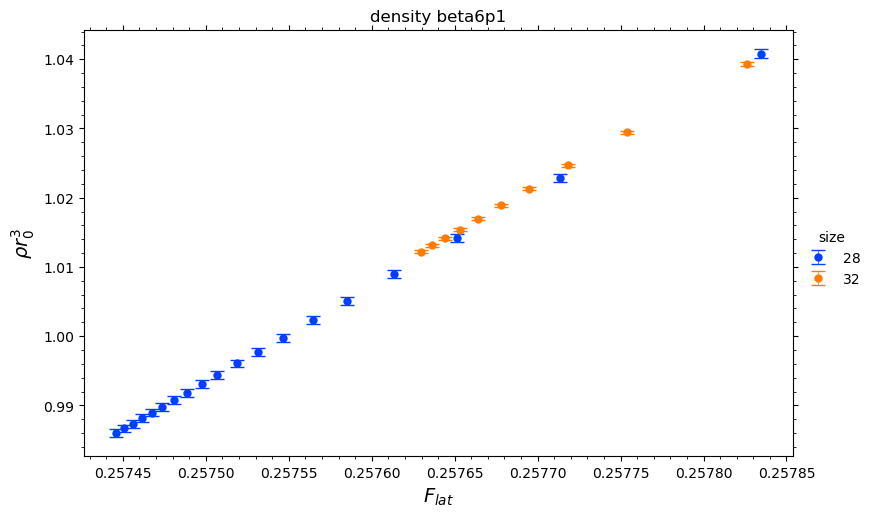

In [10]:
df = []
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_28^4_beta_6p1_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_36^4_beta_6p1_steps_0'))
df = pd.concat(df)
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'size', r'$F_{lat}$', r'$\rho r_{0}^{3}$', 'density beta6p1', '../../images/monopoles/su3/gluodynamics', 'density_beta6p1', True, err='std_density', save_figure=True)

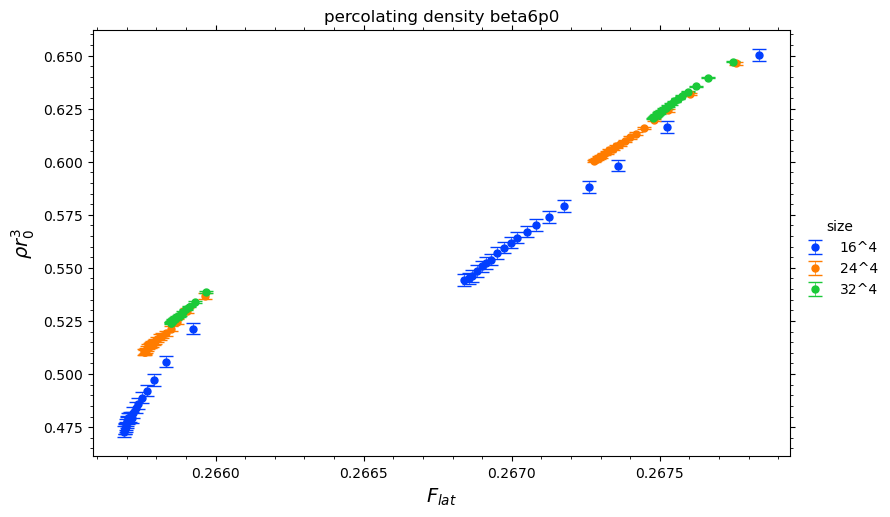

In [11]:
df = []
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_16^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_16^4_beta_6p0_steps_500'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_24^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_24^4_beta_6p0_steps_100'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_32^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_size_32^4_beta_6p0_steps_100'))
df = pd.concat(df)
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'size', r'$F_{lat}$', r'$\rho r_{0}^{3}$', 'percolating density beta6p0', '../../images/monopoles/su3/gluodynamics', 'percolating_density_beta6p0', True, err='std_density', save_figure=True)

In [6]:
def make_plot_density(data, x, y, hue, x_label, y_label, title, image_path, image_name, show_plot, err=None, df_fits=None, black_line_y=None, dashed_line_y=None, markers_different=False, color_palette='bright', save_figure=False):
    markers_arr = ['o', '^', 's', 'D', 'P', 'X', 'v', '*']
    if hue is not None:
        hues = data[hue].unique()
        n_colors = hues.shape[0]
        color_palette = seaborn.color_palette(palette=color_palette, n_colors=n_colors)
        potential_type_hue = dict(zip(data[hue].unique(), hues))
        color_palette = dict(zip(hues, color_palette))
        markers_hue = markers_arr[:len(hues)]
    else:
        color_palette = None
        markers_hue = None
    #hue_kws=dict(marker=markers_hue)
    fg_kws = {}
    if markers_different:
        # fg_kws['hue_kws'] = dict(marker=markers_hue)
        fg_kws['hue_kws'] = {'marker': markers_hue, 'mfc': ['w', 'w', 'w']}
        print({'marker': markers_hue})
        print(dict(marker=markers_hue))
    fg = seaborn.FacetGrid(data=data, hue=hue, height=5,
                           aspect=1.4, palette=color_palette, legend_out=True, **fg_kws)
    if err is not None:
        fg.map(plt.errorbar, x, y, err, mfc=None, fmt='o', ms=6, capsize=5, lw=0.5, ls=None
           )#.add_legend()
    else:
        fg.map(plt.errorbar, x, y, mfc=None, fmt='o', ms=6, capsize=5, lw=0.5, ls=None
           )#.add_legend()
    # lines = fg.get_lines()
    for ax in fg.axes.flat:
        lines = ax.lines
        [l.set_color('black') for l in lines]
    plt.legend()
    fg.ax.set_xlabel(x_label, fontsize=14)
    fg.ax.set_ylabel(y_label, fontsize=14)
    # fg.figure.suptitle(title)
    fg.ax.set_title(title)
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which='both', bottom=True,
                      top=True, left=True, right=True)
    # plt.grid(dash_capstyle='round')
    if black_line_y is not None:
        plt.axhline(y=black_line_y, color='r', linestyle='-')

    if dashed_line_y is not None:
        for coord in dashed_line_y:
            plt.axhline(y=coord, color='r', linestyle='--')

    if df_fits is not None:
        for key in df_fits[hue].unique():
            plt.plot(df_fits[df_fits[hue] == key][x], df_fits[df_fits[hue] == key][y],
                     color=color_palette[potential_type_hue[key]], linewidth=1)

    if show_plot:
        plt.show()
    if save_figure:
        save_image(f'{image_path}',
            f'{image_name}', fg)
    return fg

{'marker': ['o', '^', 's']}
{'marker': ['o', '^', 's']}


/home/ilya/anaconda3/envs/python3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/anaconda3/envs/python3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/anaconda3/envs/python3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)


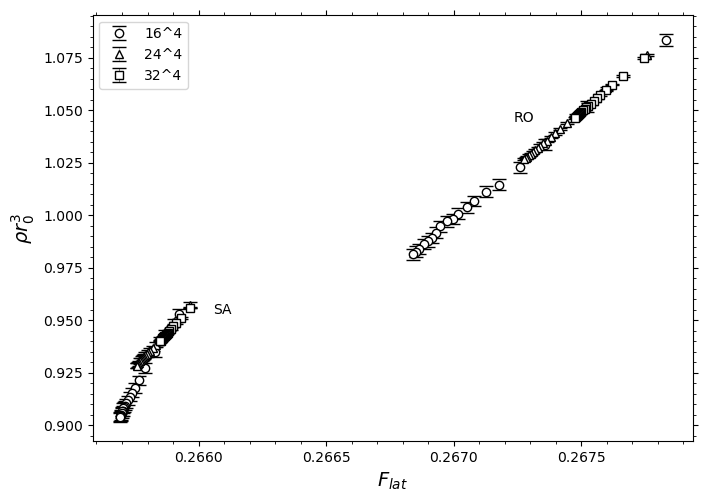

In [7]:
df = []
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_16^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_16^4_beta_6p0_steps_500'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_24^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_24^4_beta_6p0_steps_100'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_32^4_beta_6p0_steps_0'))
df.append(pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size_32^4_beta_6p0_steps_100'))
df = pd.concat(df)
df.to_csv('../../result/monopoles/su3/gluodynamics/density_beta6p0', index=False)
df['functional'] = (1 - df['functional']) * 3/2
fg = make_plot_density(df, 'functional', 'density', 'size', r'$F_{lat}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'density_beta6p0', False, err='std_density', markers_different=True, color_palette='Greys')
plt.text(0.7, 0.75, 'RO', transform=fg.ax.transAxes)
plt.text(0.2, 0.3, 'SA', transform=fg.ax.transAxes)
# plt.text(1.0, 0.26652, r'Hello, world!', fontsize=15)
plt.show()
plots.save_image('../../images/monopoles/su3/gluodynamics', 'density_beta6p0', fg)

/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument 

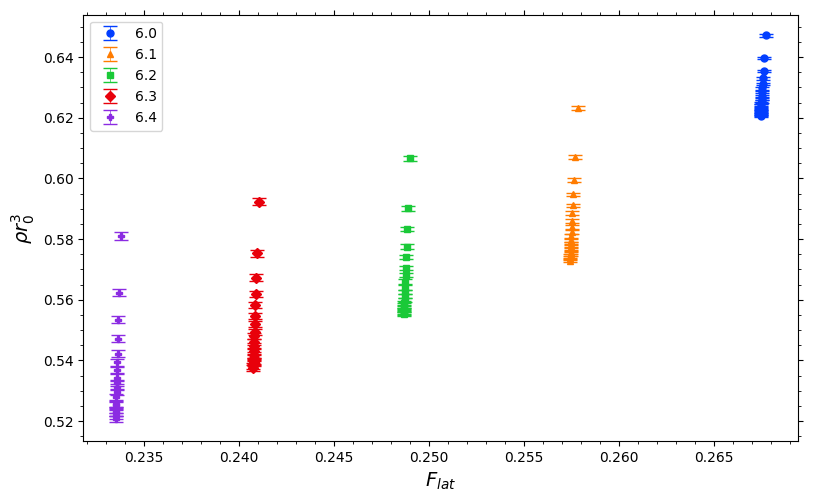

In [10]:
df = pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_beta')
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'beta', r'$F_{lat}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'percolating current density beta', True, err='std_density', save_figure=True)

/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument 

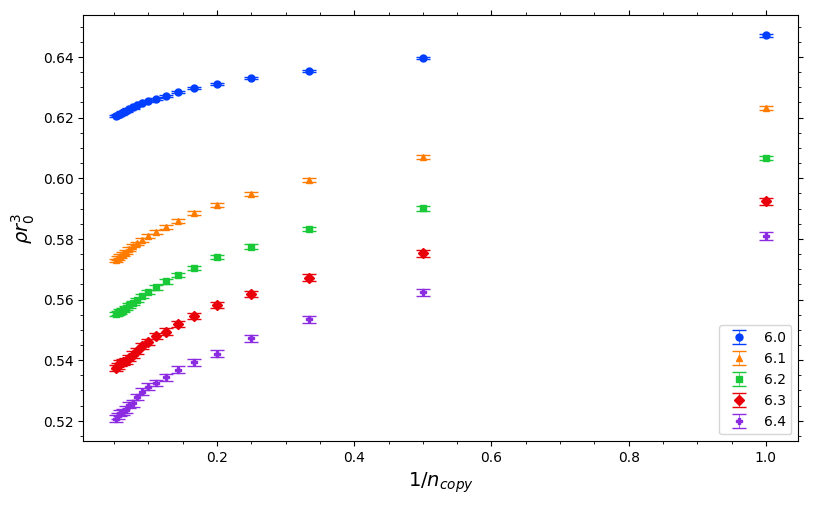

In [11]:
df = pd.read_csv('../../result/monopoles/su3/gluodynamics/percolating_density_beta')
df['functional'] = (1 - df['functional']) * 3/2
df['inv_copy'] = 1/df['copy']
plots.make_plot(df, 'inv_copy', 'density', 'beta', r'$1/n_{copy}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'percolating current density beta inv copy', True, err='std_density', save_figure=True)

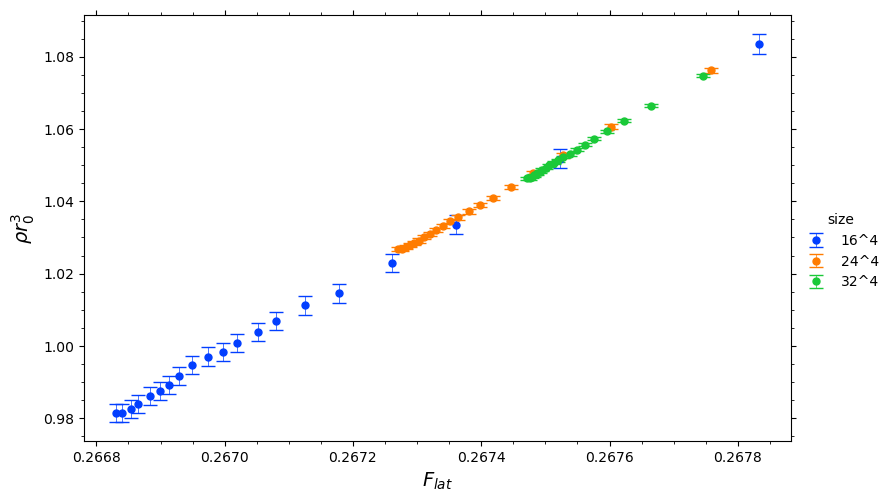

In [13]:
df = pd.read_csv('../../result/monopoles/su3/gluodynamics/density_size')
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'size', r'$F_{lat}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'current density size', True, err='std_density', save_figure=True)

/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument 

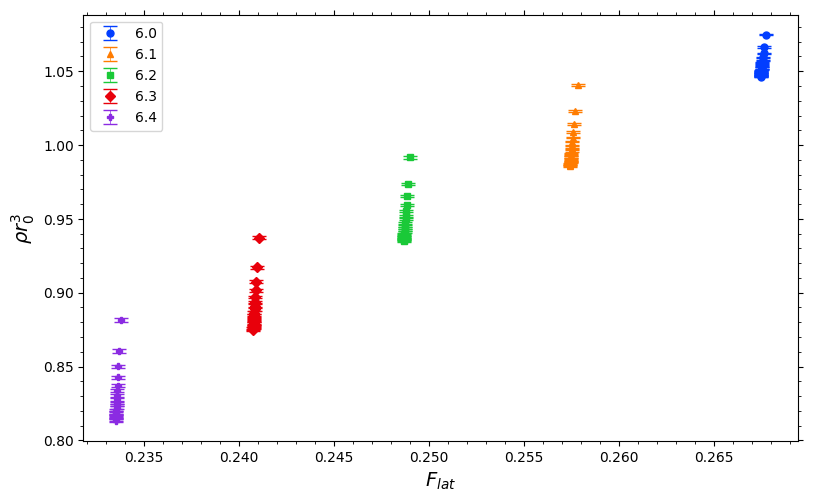

In [13]:
df = pd.read_csv('../../result/monopoles/su3/gluodynamics/density_beta')
df['functional'] = (1 - df['functional']) * 3/2
plots.make_plot(df, 'functional', 'density', 'beta', r'$F_{lat}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'current density beta', True, err='std_density', save_figure=True)

/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument 

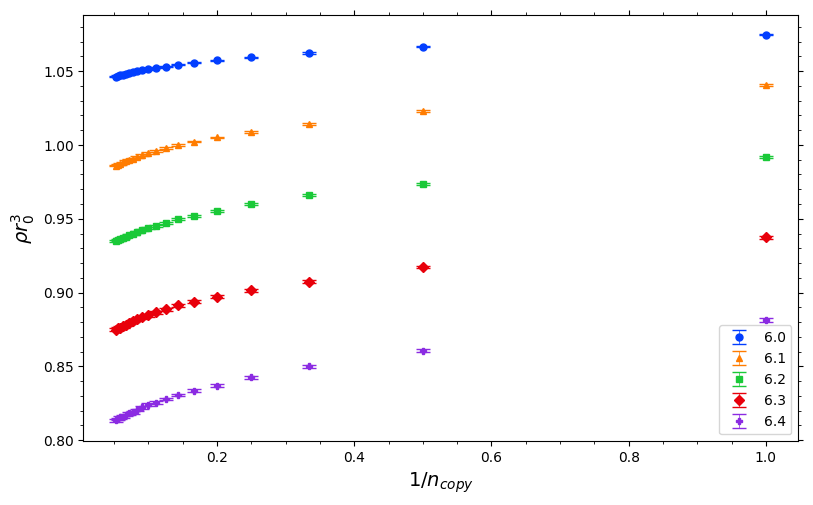

In [14]:
df = pd.read_csv('../../result/monopoles/su3/gluodynamics/density_beta')
df['functional'] = (1 - df['functional']) * 3/2
df['inv_copy'] = 1/df['copy']
plots.make_plot(df, 'inv_copy', 'density', 'beta', r'$1/n_{copy}$', r'$\rho r_{0}^{3}$', '', '../../images/monopoles/su3/gluodynamics', 'current density beta inv copy', True, err='std_density', save_figure=True)

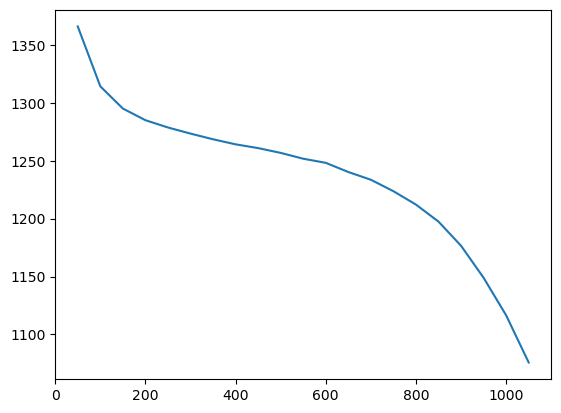

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2, 'padding': 5}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2, 'padding': 5}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 50, 1100, 50, ['conf'], image_path, image_name)

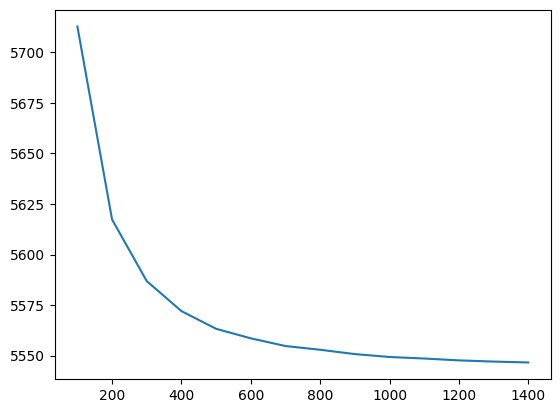

In [7]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 1500, 100, ['conf'], image_path, image_name)

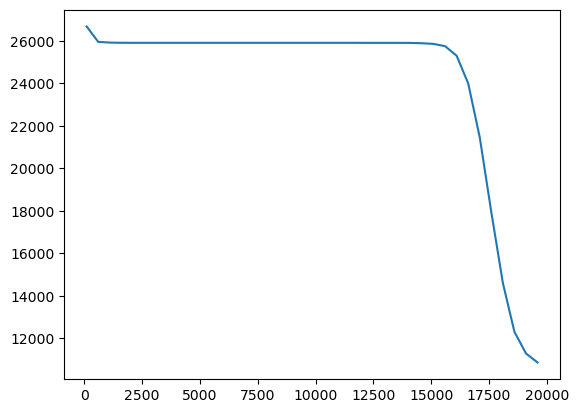

In [9]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 20100, 500, ['conf'], image_path, image_name)

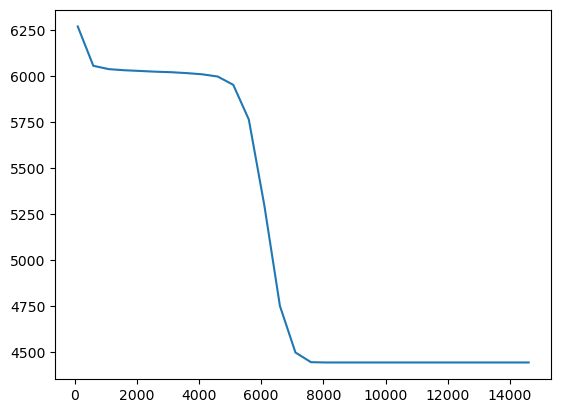

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 1}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 1}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 15000, 500, ['conf'], image_path, image_name)

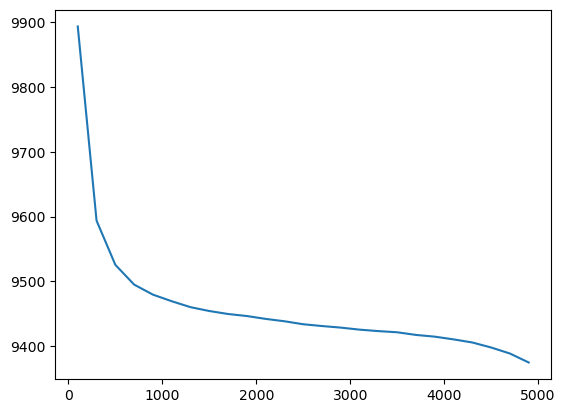

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 5000, 200, ['conf'], image_path, image_name)

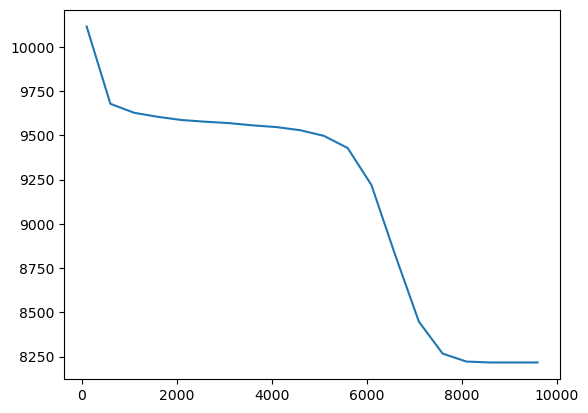

In [6]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 10000, 500, ['conf'], image_path, image_name)

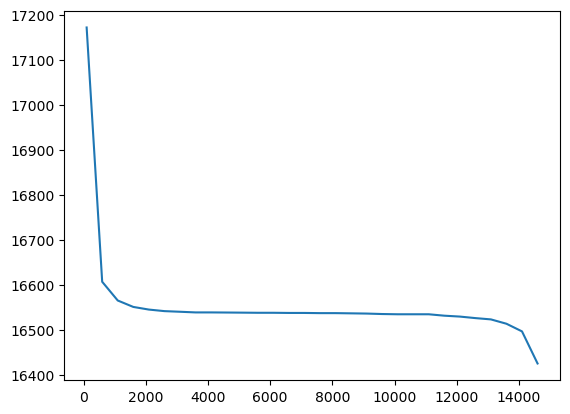

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 6000), 'parameters': {'size': '36^4'}, 'copies_num': 1}]
paths_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.1/steps_0/copies=10/s3/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 6000), 'parameters': {'size': '36^4'}, 'copies_num': 1}]
image_path = '../images/monopoles_su3/gluodynamics/36^4/beta6.1'
image_name = 'percolating_cluster_steps_0'
percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 15000, 500, ['conf'], image_path, image_name)

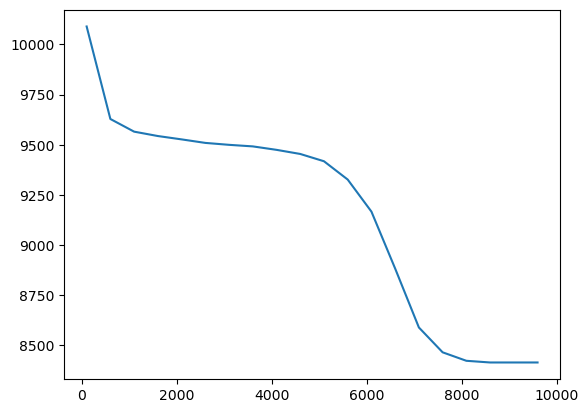

In [46]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
paths_unwrapped = [ {'path': '../../data/monopoles_su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'size': '16^4'}, 'copies_num': 2}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 10000, 500, ['conf'], image_path, image_name)

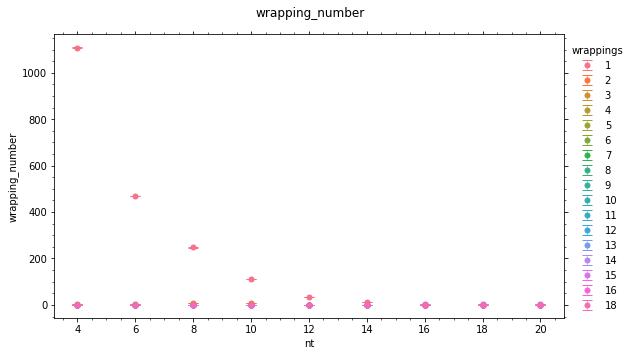

../../images/monopoles/su3/QCD/140MeV/wrappings_together


In [ ]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
make_plot(df, 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_together', hue='wrappings', err='std')

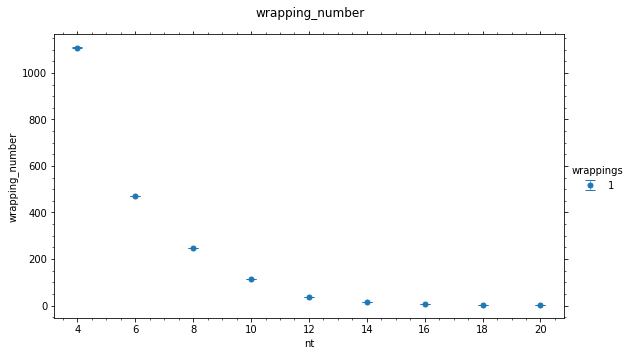

../../images/monopoles/su3/QCD/140MeV/wrappings_1


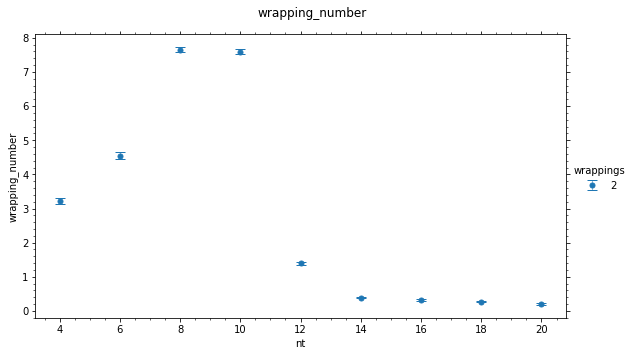

../../images/monopoles/su3/QCD/140MeV/wrappings_2


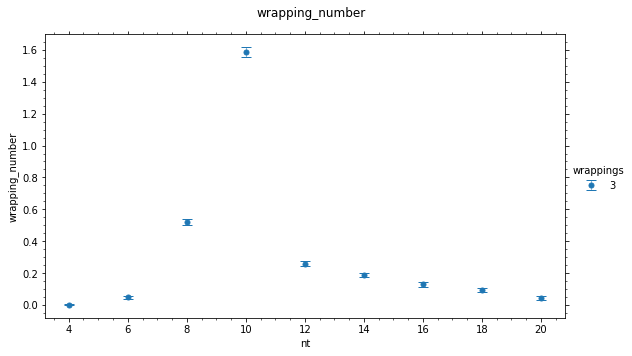

../../images/monopoles/su3/QCD/140MeV/wrappings_3


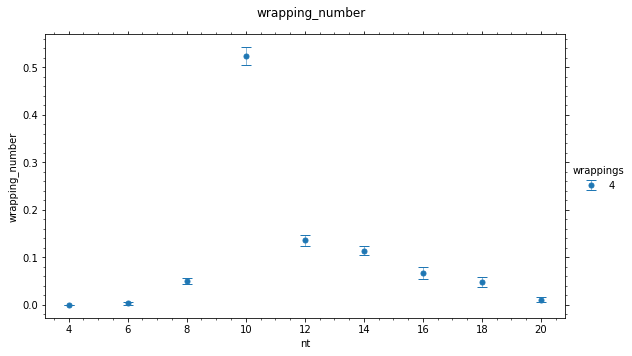

../../images/monopoles/su3/QCD/140MeV/wrappings_4


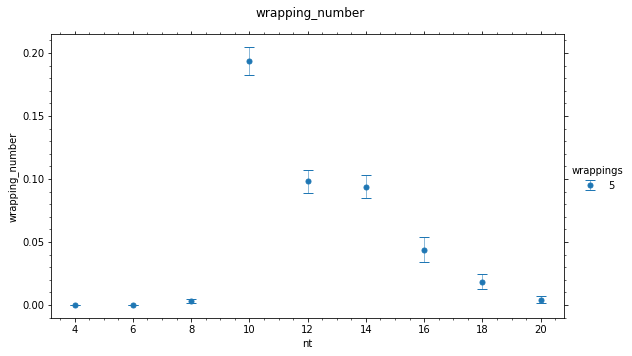

../../images/monopoles/su3/QCD/140MeV/wrappings_5


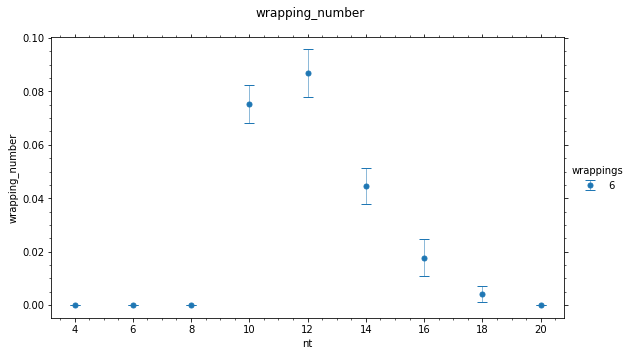

../../images/monopoles/su3/QCD/140MeV/wrappings_6


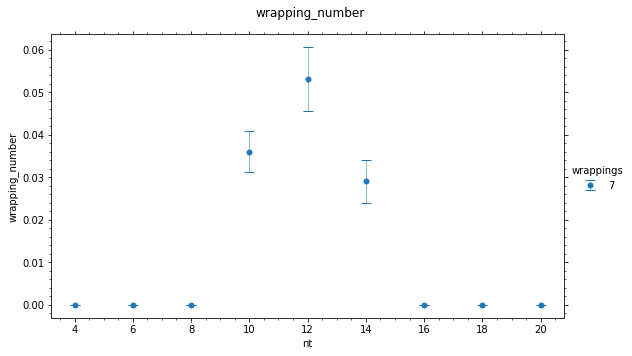

../../images/monopoles/su3/QCD/140MeV/wrappings_7


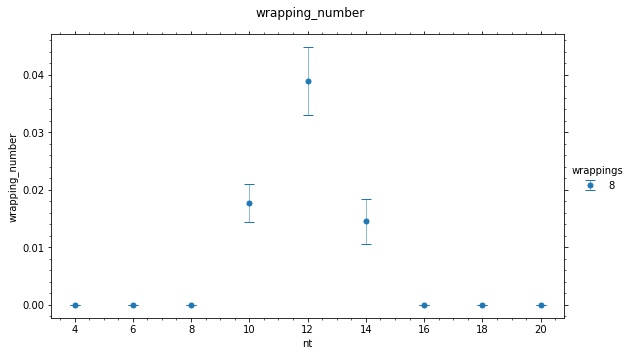

../../images/monopoles/su3/QCD/140MeV/wrappings_8


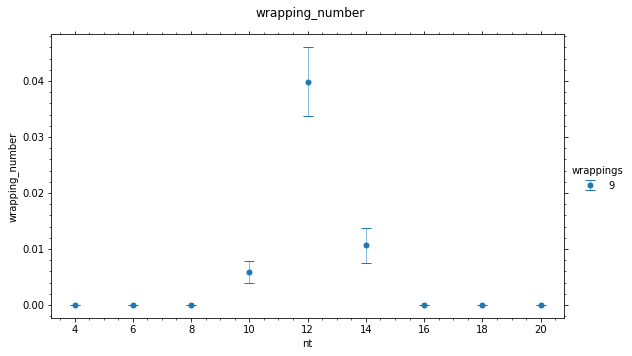

../../images/monopoles/su3/QCD/140MeV/wrappings_9


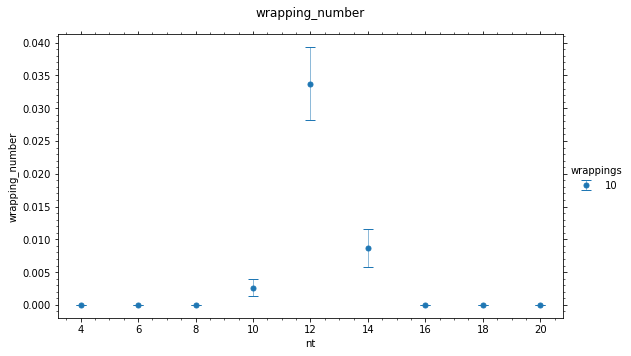

../../images/monopoles/su3/QCD/140MeV/wrappings_10


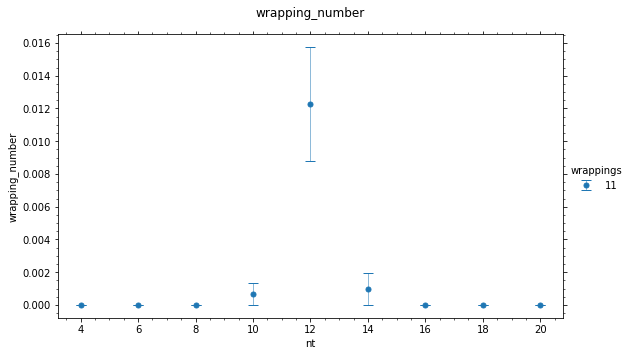

../../images/monopoles/su3/QCD/140MeV/wrappings_11


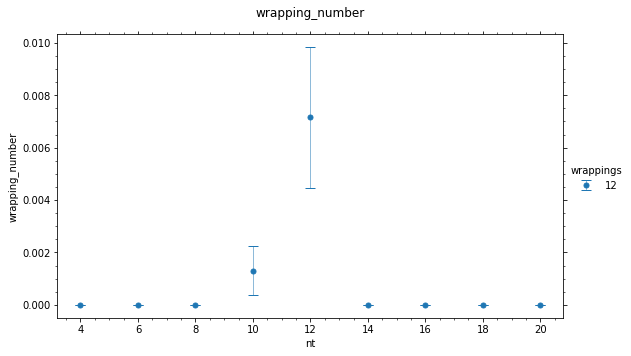

../../images/monopoles/su3/QCD/140MeV/wrappings_12


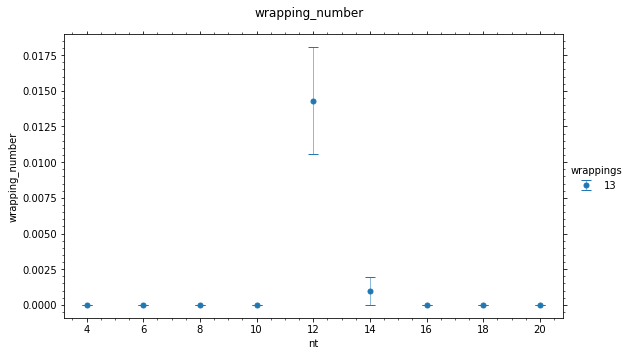

../../images/monopoles/su3/QCD/140MeV/wrappings_13


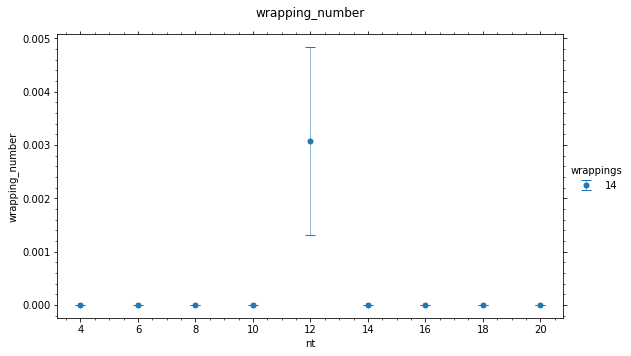

../../images/monopoles/su3/QCD/140MeV/wrappings_14


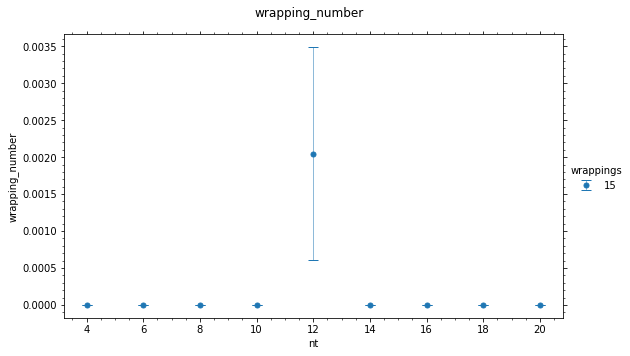

../../images/monopoles/su3/QCD/140MeV/wrappings_15


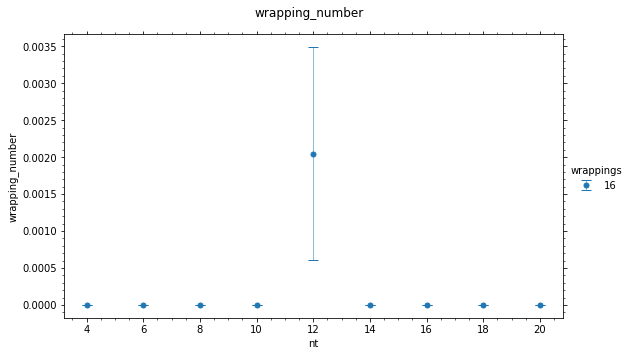

../../images/monopoles/su3/QCD/140MeV/wrappings_16


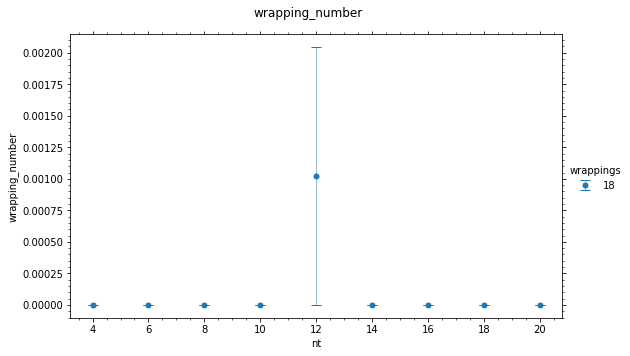

../../images/monopoles/su3/QCD/140MeV/wrappings_18


In [8]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
for wrap in df['wrappings'].unique():
    make_plot(df[df['wrappings'] == wrap], 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', f'wrappings_{wrap}', hue='wrappings', err='std')
# df.groupby('wrappings').apply(make_plot, 'nt', 'wrapping_number', 'wrapping_number', '../../images/monopoles/QCD/140MeV', 'wrappings', hue='wrappings', err='std')

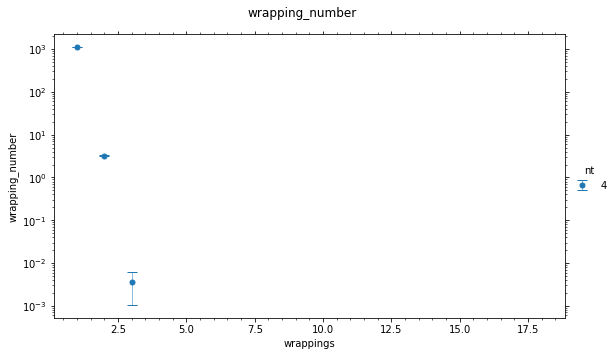

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=4


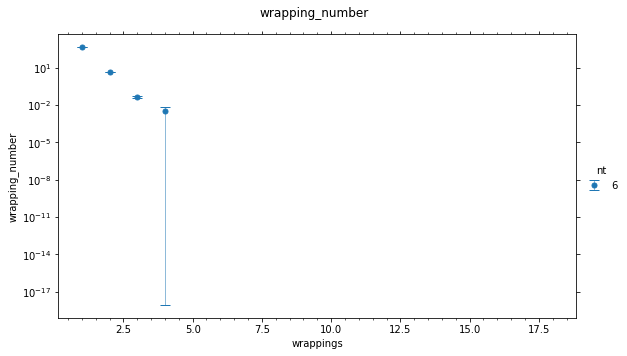

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=6


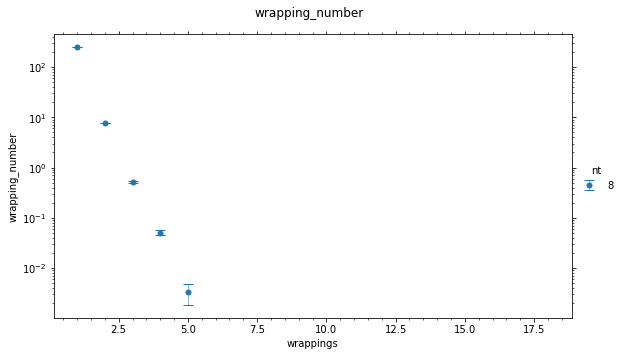

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=8


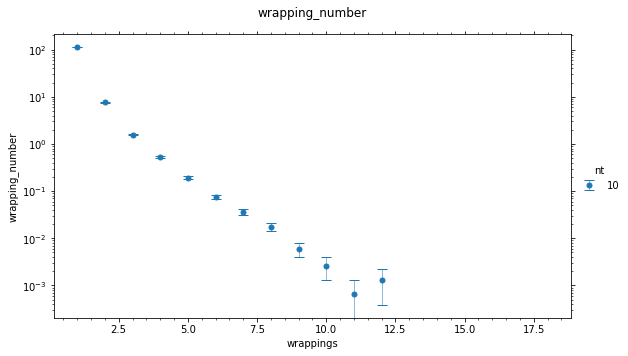

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=10


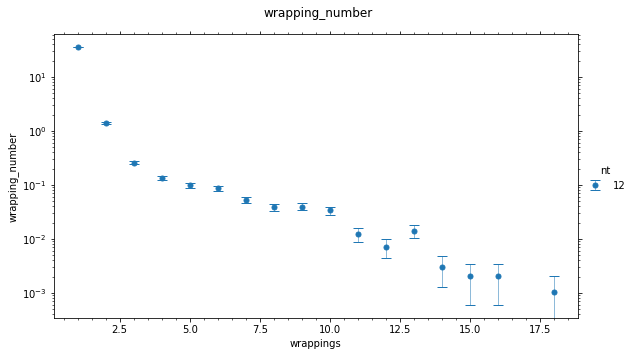

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=12


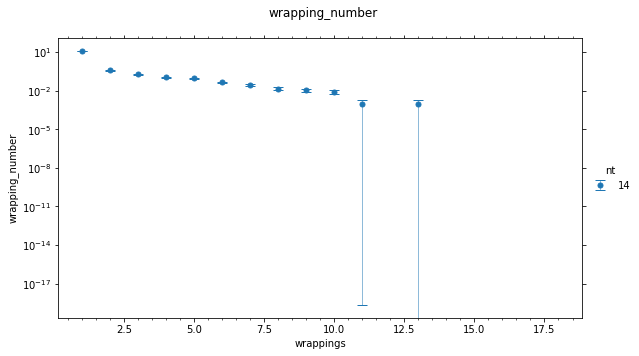

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=14


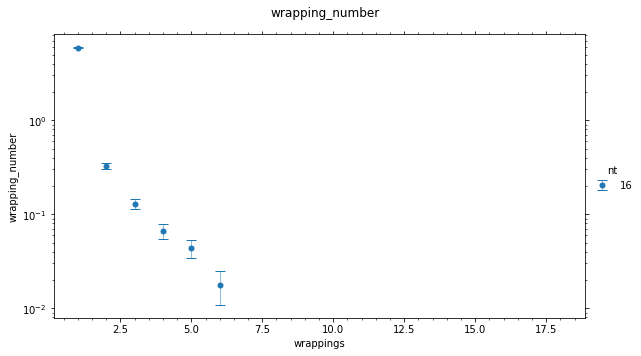

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=16


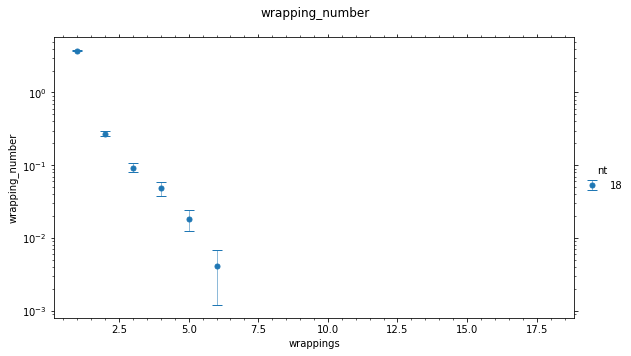

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=18


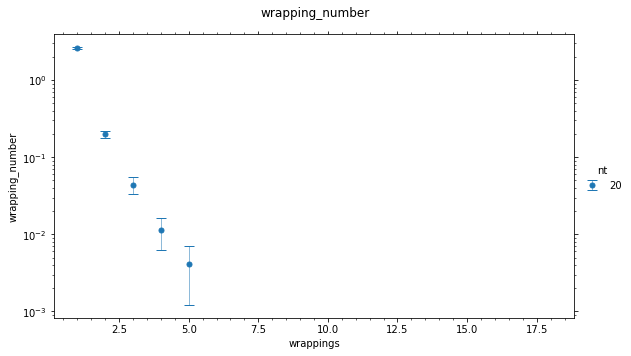

../../images/monopoles/su3/QCD/140MeV/wrapping_number_nt=20


In [13]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 1000000, ['nt'])
# make_plot(df, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/QCD/140MeV', 'wrapping_nt', hue='nt', err='std')
for nt in df['nt'].unique():
    make_plot(df[df['nt'] == nt], 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', f'wrapping_number_nt={nt}', hue='nt', err='std')
# df.groupby('nt').apply(make_plot, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrapping_number_nt', hue='nt', err='std')

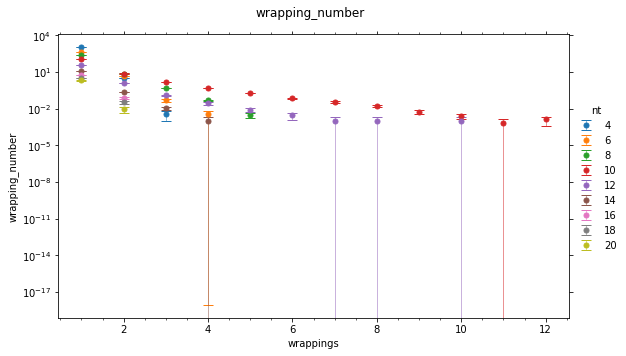

../../images/monopoles/su3/QCD/140MeV/wrappings_nt_together


In [12]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings_separate(paths_wrapped, 50000, ['nt'])
make_plot(df, 'wrappings', 'wrapping_number', 'wrapping_number', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_nt_together', hue='nt', err='std')

In [11]:
def percolating_cluster_average(paths_wrapped, paths_unwrapped, groupby_keys, length_threshold, x, y, title, image_path, image_name, hue=None, err=None):
    df_clusters_wrapped = monopole_data.read_data_wrapped(paths_wrapped)
    df_clusters_unwrapped = monopole_data.read_data_unwrapped(paths_unwrapped)
    data_clusters = percolating_cluster.clusters_divide(df_clusters_unwrapped, df_clusters_wrapped, length_threshold, groupby_keys + ['conf'])
    print(data_clusters)
    data_clusters = data_clusters.groupby(groupby_keys)['length'].agg([('length', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys)
    print(data_clusters)
    make_plot(data_clusters, x, y, title, image_path, image_name, hue=hue)

      nt  conf         length
0      4   501     132.666667
1      4   502     105.333333
2      4   503     112.666667
3      4   504     116.666667
4      4   505     127.333333
...   ..   ...            ...
2540  20   694  161860.666667
2541  20   696  164998.666667
2542  20   697  161943.333333
2543  20   698  161780.000000
2544  20   699  163526.000000

[2545 rows x 3 columns]
   nt         length         std
0   4     117.119430    0.917482
1   6     334.550427    3.268953
2   8    1241.147256   10.338988
3  10    9437.643746  135.681859
4  12   66681.577982  308.126970
5  14   94752.381783  122.850770
6  16  128825.237500  194.167577
7  18  145410.879346  208.985641
8  20  164830.176955  267.196923


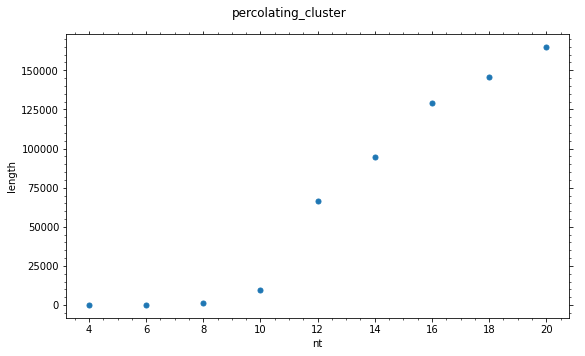

../../images/monopoles/su3/QCD/140MeV/percolating_cluster_nt


In [12]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
paths_unwrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
percolating_cluster_average(paths_wrapped, paths_unwrapped, ['nt'], 10000, 'nt', 'length', 'percolating_cluster', '../../images/monopoles/su3/QCD/140MeV', 'percolating_cluster_nt', err='std')

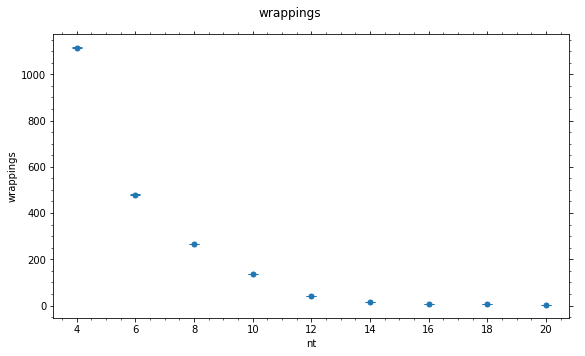

../../images/monopoles/su3/QCD/140MeV/wrappings_average


In [13]:
paths_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
                 {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
df = wrappings.wrappings(paths_wrapped, 10000000, ['nt'])
make_plot(df, 'nt', 'wrappings', 'wrappings', '../../images/monopoles/su3/QCD/140MeV', 'wrappings_average', err='std')

In [14]:
def cluster_number_normalize(df):
    norm_factor = df.at[df['length'].idxmin(), 'number']
    df['number'] = df['number'] / norm_factor
    df['std'] = df['std'] / norm_factor
    return df

def cluster_number_aver(paths, length_threshold, groupby_keys, image_path, image_name, hue=None):
    df = monopole_data.read_data_unwrapped(paths)
    df = df[df['length'] < length_threshold]
    df = df.set_index(groupby_keys + ['color', 'conf', 'length']).unstack(['length'], fill_value=0).stack().reset_index()
    df = df.groupby(groupby_keys + ['length', 'conf'])['number'].agg([('number', np.mean)]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys + ['length'])['number'].agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys, group_keys=False).apply(cluster_number_normalize)
    make_plot(df, 'length', 'number', 'length distribution of non-percolating clusters', image_path, image_name, hue=hue, err='std')

def cluster_number_aver_copies(paths, length_threshold, groupby_keys, image_path, image_name, hue=None):
    df = monopole_data.read_data_unwrapped_copies(paths)
    df = df[df['length'] < length_threshold]
    df = df.set_index(groupby_keys + ['color', 'conf', 'length']).unstack(['length'], fill_value=0).stack().reset_index()
    df = df.groupby(groupby_keys + ['length', 'conf'])['number'].agg([('number', np.mean)]).reset_index(level=groupby_keys + ['length'])
    df = df.groupby(groupby_keys + ['length'])['number'].agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index(level=groupby_keys + ['length'])
    # df = df.groupby(groupby_keys, group_keys=False).apply(cluster_number_normalize)
    make_plot(df, 'length', 'number', 'length distribution of non-percolating clusters', image_path, image_name, hue=hue, err='std')

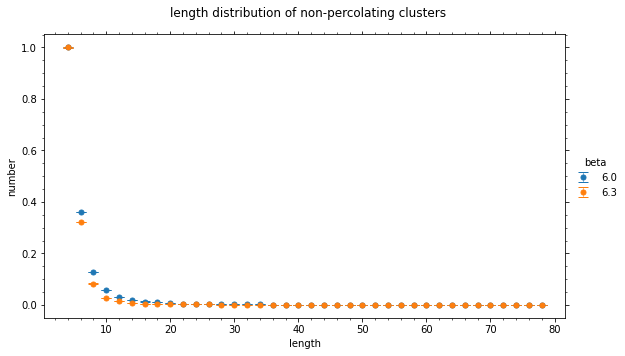

../../images/monopoles/su3/cluster_length_distribution_beta6p0_6p3


In [15]:
paths = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.0}},
         {'path': '../../data/monopoles_su3/gluodynamics/36^4/beta6.3/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'beta': 6.3}}]
cluster_number_aver(paths, 80, ['beta'], '../../images/monopoles/su3', 'cluster_length_distribution_beta6p0_6p3', hue='beta')

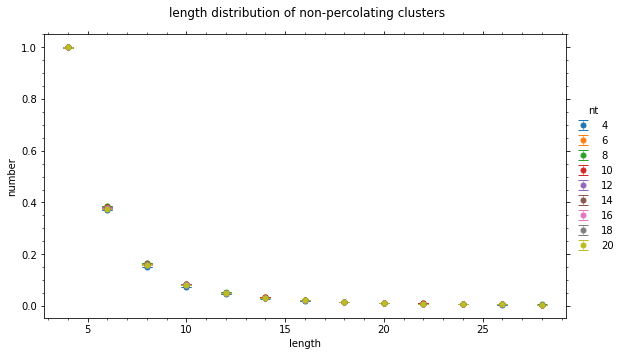

../../images/su3/QCD/140MeV/cluster_length_distribution_QCD_140MeV


In [16]:
paths = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt4/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 4}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt6/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 6}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt8/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 8}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt10/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 10}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt12/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 12}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 14}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt16/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 16}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt18/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 18}},
         {'path': '../../data/monopoles_su3/QCD/140MeV/nt20/steps_500/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [1, 1500], 'parameters': {'nt': 20}}]
cluster_number_aver(paths, 30, ['nt'], '../../images/su3/QCD/140MeV', 'cluster_length_distribution_QCD_140MeV', hue='nt')

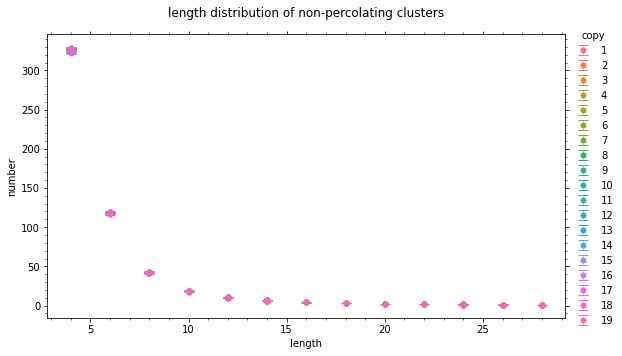

../../images/su3/gluodynamics/24^4/beta6.0/cluster_length_distribution_beta6p0


In [18]:
paths = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20}]
cluster_number_aver_copies(paths, 30, ['copy', 'steps'], '../../images/su3/gluodynamics/24^4/beta6.0', 'cluster_length_distribution_beta6p0', hue='copy')

In [19]:
# percolating cluster for each configuration depending on functional

def percolating_cluster_conf(paths_functional, paths_clusters_wrapped, paths_clusters_unwrapped, copies_several, groupby_keys, length_threshold, x, y, title, image_path, image_name, hue=None, err=None):
    df_func = read_functional(paths_functional)
    if copies_several:
        df_clusters_wrapped = monopole_data.read_data_wrapped_copies(paths_clusters_wrapped)
        df_clusters_unwrapped = monopole_data.read_data_unwrapped_copies(paths_clusters_unwrapped)
    else:
        df_clusters_wrapped = monopole_data.read_data_wrapped(paths_clusters_wrapped)
        df_clusters_unwrapped = monopole_data.read_data_unwrapped(paths_clusters_unwrapped)
    data_clusters = percolating_cluster.clusters_divide(df_clusters_unwrapped, df_clusters_wrapped, length_threshold, groupby_keys)
    data_clusters = data_clusters.merge(df_func, how='inner', on=groupby_keys)
    make_plot(data_clusters, x, y, title, image_path, image_name, hue=hue, err=err)

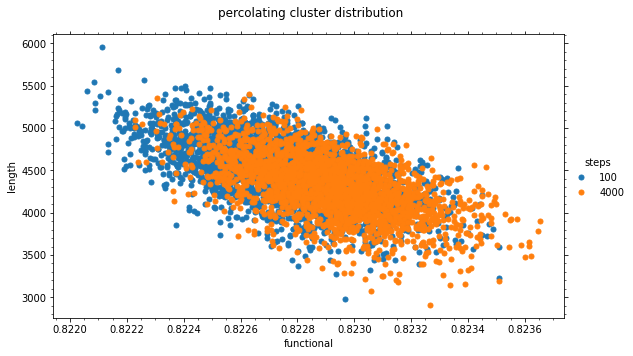

../../images/monopoles/su3/beta6.0/mag_dependence/percolating_cluster_mag_dependence_beta6p0_steps=100


In [20]:
params_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 100}},
                    {'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/functional', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_100/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 100}, 'copies_num': 20},
                    {'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_4000/copies=20/0.01/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 1000), 'parameters': {'steps': 4000}, 'copies_num': 20}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, 'True', ['conf', 'copy', 'steps'], 1500, 'functional', 'length', 'percolating cluster distribution', '../../images/monopoles/su3/beta6.0/mag_dependence',
                        'percolating_cluster_mag_dependence_beta6p0_steps=100', hue='steps')

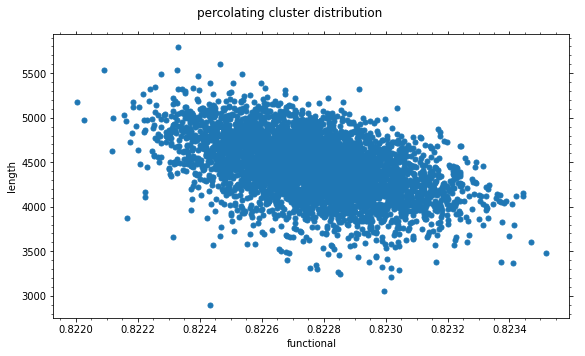

../../images/monopoles/su3/beta6.0/mag_dependence/percolating_cluster_mag_dependence_beta6p0_steps=500


In [21]:
params_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/functional', 'conf_range': (1, 5000)}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000), 'parameters': {'copy': 4}}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000), 'parameters': {'copy': 4}}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, False, ['conf', 'copy'], 1500, 'functional', 'length', 'percolating cluster distribution',
                         '../../images/monopoles/su3/beta6.0/mag_dependence', 'percolating_cluster_mag_dependence_beta6p0_steps=500')

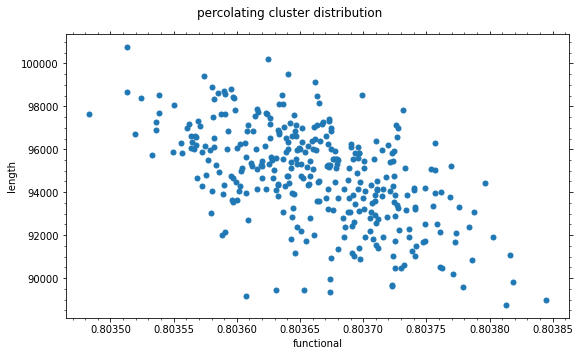

../../images/monopoles/su3/QCD/140MeV/nt14/mag_dependence/percolating_cluster_mag_dependence_nt14


In [22]:
params_functional = [{'path': '../../data/mag/functional/su3/QCD/140MeV/nt14/steps_2000/copies=1/functional', 'conf_range': [501, 860]}]
params_clusters_wrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_wrapped/clusters_wrapped', 'conf_range': [501, 860]}]
params_clusters_unwrapped = [{'path': '../../data/monopoles_su3/QCD/140MeV/nt14/steps_2000/copies=1/clusters_unwrapped/clusters_unwrapped', 'conf_range': [501, 860]}]
percolating_cluster_conf(params_functional, params_clusters_wrapped, params_clusters_unwrapped, False, ['conf'], 50000, 'functional', 'length', 'percolating cluster distribution',
                         '../../images/monopoles/su3/QCD/140MeV/nt14/mag_dependence', 'percolating_cluster_mag_dependence_nt14')

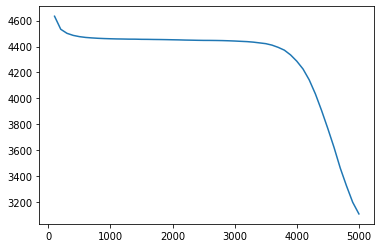

In [5]:
paths_wrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_wrapped/clusters_wrapped', 'conf_range': (1, 5000)}]
paths_unwrapped = [{'path': '../../data/monopoles_su3/gluodynamics/24^4/beta6.0/steps_500/copies=4/clusters_unwrapped/clusters_unwrapped', 'conf_range': (1, 5000)}]
image_path = '../images/monopoles_su3/gluodynamics/24^4/beta6.0'
image_name = 'percolating_cluster_steps_500'

percolating_cluster.percolating_clusters(paths_unwrapped, paths_wrapped, 100, 5001, 100, ['conf'], image_path, image_name)